## set up notebook

In [1]:
#reload when modified
%load_ext autoreload
%autoreload 2
#activate r magic
%load_ext rpy2.ipython
%matplotlib inline

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as UT
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc

random.seed(1976)
np.random.seed(1976)

ModuleNotFoundError: No module named 'sklearn'

# Data Anaylsis

## Experiment SetUp

In [3]:
from IPython.display import Image

 <img src="Figures/Figure_1.jpeg" width="800" height="800" />

In [4]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='gene']
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    for n in gff.iloc[:,-1]:
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        #print (item_list)
        temp_dict = {}
        for m in item_list:
            #print(m)
            temp_dict[m.split('=')[0].strip()]=m.split('=')[1].strip()
        #print(temp_dict['ID'])
        #print(temp_dict['description'])
        desc[temp_dict['ID']]=temp_dict.get('description','none')
    return desc

desc_dict = make_desc('InData/TriTrypDB-46_TbruceiTREU927.gff')
desc_dict['Tb10.v4.0073']

'variant surface glycoprotein (VSG  pseudogene)  putative'

In [5]:
#combine read counts
exp = '{life_stage}_{fraction}_{replica}'
list_df = [exp.format(
    life_stage=life_stage,
    fraction=fraction,
    replica=replica) 
 for life_stage in ['B','P']
 for fraction in ['tot','pol','sub']
 for replica in ['1','2','3']
            ]
list_df = [n+'/res3/'+n+'/counts.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in list_df[1:]:
    df = df.join(temp_df.iloc[:,-1])
df.head()
#temp_df = pd.read_csv('BSF/tb927_3_ks_counts_final.txt',index_col=[0],comment='#',sep='\t')

,Chr,Start,End,Strand,Length,/tmp/2109.1.all.q/B_tot_1/B_tot_1_sorted.bam,/tmp/2112.1.all.q/B_tot_2/B_tot_2_sorted.bam,/tmp/2115.1.all.q/B_tot_3/B_tot_3_sorted.bam,/tmp/2108.1.all.q/B_pol_1/B_pol_1_sorted.bam,/tmp/2111.1.all.q/B_pol_2/B_pol_2_sorted.bam,...,/tmp/2116.1.all.q/B_sub_3/B_sub_3_sorted.bam,/tmp/2118.1.all.q/P_tot_1/P_tot_1_sorted.bam,/tmp/2121.1.all.q/P_tot_2/P_tot_2_sorted.bam,/tmp/2124.1.all.q/P_tot_3/P_tot_3_sorted.bam,/tmp/2117.1.all.q/P_pol_1/P_pol_1_sorted.bam,/tmp/2120.1.all.q/P_pol_2/P_pol_2_sorted.bam,/tmp/2123.1.all.q/P_pol_3/P_pol_3_sorted.bam,/tmp/2119.1.all.q/P_sub_1/P_sub_1_sorted.bam,/tmp/2122.1.all.q/P_sub_2/P_sub_2_sorted.bam,/tmp/2125.1.all.q/P_sub_3/P_sub_3_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,1,1,0,0,0,...,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
data_col = df.columns[5:]
data_col

Index(['/tmp/2109.1.all.q/B_tot_1/B_tot_1_sorted.bam',
       '/tmp/2112.1.all.q/B_tot_2/B_tot_2_sorted.bam',
       '/tmp/2115.1.all.q/B_tot_3/B_tot_3_sorted.bam',
       '/tmp/2108.1.all.q/B_pol_1/B_pol_1_sorted.bam',
       '/tmp/2111.1.all.q/B_pol_2/B_pol_2_sorted.bam',
       '/tmp/2114.1.all.q/B_pol_3/B_pol_3_sorted.bam',
       '/tmp/2110.1.all.q/B_sub_1/B_sub_1_sorted.bam',
       '/tmp/2113.1.all.q/B_sub_2/B_sub_2_sorted.bam',
       '/tmp/2116.1.all.q/B_sub_3/B_sub_3_sorted.bam',
       '/tmp/2118.1.all.q/P_tot_1/P_tot_1_sorted.bam',
       '/tmp/2121.1.all.q/P_tot_2/P_tot_2_sorted.bam',
       '/tmp/2124.1.all.q/P_tot_3/P_tot_3_sorted.bam',
       '/tmp/2117.1.all.q/P_pol_1/P_pol_1_sorted.bam',
       '/tmp/2120.1.all.q/P_pol_2/P_pol_2_sorted.bam',
       '/tmp/2123.1.all.q/P_pol_3/P_pol_3_sorted.bam',
       '/tmp/2119.1.all.q/P_sub_1/P_sub_1_sorted.bam',
       '/tmp/2122.1.all.q/P_sub_2/P_sub_2_sorted.bam',
       '/tmp/2125.1.all.q/P_sub_3/P_sub_3_sorted.bam'],
      dty

In [7]:
#change headers
indata = df[data_col]
indata.columns = [n.split('/')[3].replace('_sorted.bam','') for  n in indata.columns]
indata.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Geneid,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,0,0,1,1,0,0,2,2,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
print(indata.shape)
indata=indata.dropna()
print(indata.shape)

(19986, 18)
(19986, 18)


## QC - MSD
visualise differences between samples

{'r': 'BSF', 'b': 'PCF'}


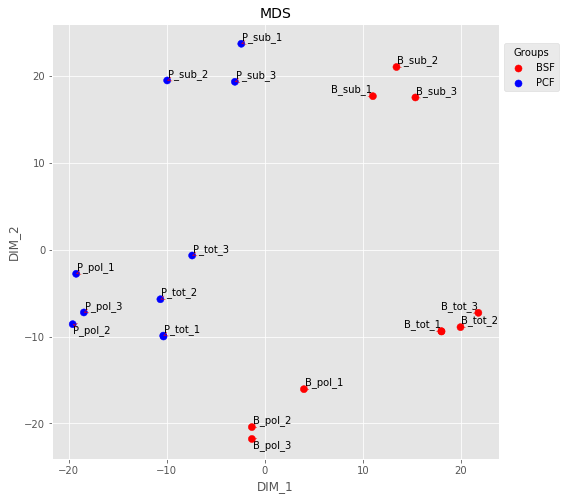

In [9]:
plt.style.use('ggplot')
palette = ['r']*9+['b']*9
fig,ax = plt.subplots(figsize=(8,8), ncols=1, nrows=1)
UT.make_mds(np.log2(indata),palette,ax,color_dictionary={'r':'BSF','b':'PCF'})
plt.savefig('Figures/Figure_2.png')
plt.show()

## Compute Length and GC content

In [10]:
!gtf2bed < tb927_5.gtf > tb927_5.bed
!bedtools nuc -fi tb927_5.fa -bed tb927_5.bed >InData/GC_content_927.txt

In [11]:
#function to extract the gene info
#from the "bedtools nuc -fi" outputs
def get_gene_ids(n):
    res = {}
    temp = n.split(';')
    temp =[n.strip() for n in temp if len(n)>2]
    for f in temp:
        key = f.split(' ')[0]
        value = f.split(' ')[1]
        key=key.replace('\"','').replace('\'','').strip()
        value=value.replace('\"','').replace('\'','').strip()
        res[key]=value
    return res['gene_id']

In [12]:
#create a dataframe with only GC and length
#for each gene
gc_content = pd.read_csv('InData/GC_content_927.txt',sep='\t')
gc_content = gc_content[gc_content['8_usercol']=='transcript']
gc_content['gene_id'] = [get_gene_ids(n) for n in gc_content['10_usercol']]
gc_content = gc_content.drop_duplicates('gene_id')
gc_content.set_index('gene_id',inplace=True)
gc_content=gc_content[['19_seq_len','12_pct_gc']]
gc_content.columns = ['length', 'gccontent']
gc_content.head()

,length,gccontent
gene_id,,
MSTRG.1,2768,0.505419
MSTRG.2,2482,0.304593
TRY.1,746,0.273458
TRY.2,1531,0.288047
TRY.3,1390,0.379856


In [13]:
#use only gene with a read count
print(indata.shape)
indata=indata.join(gc_content,how='inner')
gc_content = gc_content[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True) 
indata.head()

(19986, 18)


,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,0,0,1,1,0,0,2,2,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Data Normalization

### edgeR to filter low counts

In [14]:
%%R -i indata
options(warn=-1)
library("limma") 
library("edgeR")
head(indata)

             B_tot_1 B_tot_2 B_tot_3 B_pol_1 B_pol_2 B_pol_3 B_sub_1 B_sub_2
Tb10.v4.0073       1       1       0       0       0       0       1       0
Tb10.v4.0074       0       0       1       1       0       0       2       2
Tb10.v4.0075       0       0       0       0       0       0       0       0
Tb10.v4.0076       0       0       0       0       0       0       0       0
Tb10.v4.0077       0       0       0       1       0       0       0       0
Tb10.v4.0078       1       0       1       1       0       1       0       5
             B_sub_3 P_tot_1 P_tot_2 P_tot_3 P_pol_1 P_pol_2 P_pol_3 P_sub_1
Tb10.v4.0073       2       0       1       2       0       0       0       0
Tb10.v4.0074       1       0       0       0       0       0       0       0
Tb10.v4.0075       0       0       0       0       0       0       0       0
Tb10.v4.0076       0       0       0       0       0       0       0       0
Tb10.v4.0077       0       0       0       0       0       0       0       0

In [15]:
%%R
group <- factor(c(
    'Btot','Btot','Btot',
    'Bpol','Bpol','Bpol',
    'Bsub','Bsub','Bsub',
    'Ptot','Ptot','Ptot',
    'Ppol','Ppol','Ppol',
    'Psub','Psub','Psub'))

y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]
counts = y$counts
genes = row.names(y)

In [16]:
%R -o counts,genes
indata = pd.DataFrame(counts,index=genes,columns=indata.columns)
indata.shape

(14389, 18)

In [17]:
indata=indata.join(gc_content,how='inner')
indata.shape

(14389, 20)

### GC / length content

In [18]:
gc_content = indata[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True)
print(indata.shape,gc_content.shape)
indata.head()

(14389, 18) (14389, 2)


,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.150,50,31,37,18,13,13,29,21,25,26,28,20,10,5,19,17,22,30
Tb927.8.230,3,0,3,2,4,6,12,15,21,1,0,0,0,0,1,0,0,0
Tb927.8.270,1125,955,867,663,621,591,653,680,696,721,495,391,266,249,304,578,640,719
Tb927.8.320,11,12,16,12,13,12,34,45,33,19,22,7,18,19,10,33,64,41
Tb927.8.370,8,5,2,7,2,9,19,10,10,2,0,1,0,0,1,0,0,1


### size factors

In [19]:
sizeFactors=indata.sum()
sizeFactors = sizeFactors.values
sizeFactors

array([38356203, 35926182, 33875911, 35578481, 38350524, 40096239,
       37049693, 32663660, 33394434, 45083155, 41266775, 31183523,
       29991616, 35702840, 33686207, 28285346, 38159631, 33243997])

In [20]:
#np.log2(gc_content['length']/1000).plot(kind='hist')

### Bias Correction
use cqn to visualise and correct for GC and length bias

In [21]:
%%R -i gc_content,indata,sizeFactors
library(cqn)
library(scales)

R[write to console]: Loading required package: mclust

R[write to console]: Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.

R[write to console]: Loading required package: nor1mix

R[write to console]: Loading required package: preprocessCore

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: quantreg

R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve




In [22]:
%%R
stopifnot(all(rownames(indata) == rownames(gc_content)))
cqn.subset <- cqn(indata, lengths = gc_content$length,
                  x = gc_content$gccontent, sizeFactors = sizeFactors,
                  verbose = TRUE)

RQ fit ..................
SQN .


In [23]:
%R cqn.subset

R object with classes: ('cqn',) mapped to:
[ListSexpV..., IntSexpVe..., IntSexpVe..., IntSexpVe..., ..., FloatSexp..., FloatSexp..., FloatSexp..., LangSexpV...]
R object with classes: ('cqn',) mapped to:
[ListSexpV..., IntSexpVe..., IntSexpVe..., IntSexpVe..., ..., FloatSexp..., FloatSexp..., FloatSexp..., LangSexpV...]
  lengths: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('RTYPES.INTSXP',) mapped to:
[7,764, 1,102, 13,000, 5,917, ..., 2,038, 540, 183, 2,061]
  sizeFactors: <class 'rpy2.robjects.vectors.IntArray'>
  R object with classes: ('array',) mapped to:
[38,356,203, 35,926,182, 33,875,911, 35,578,481, ..., 33,686,207, 28,285,346, 38,159,631, 33,243,997]
  subindex: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('RTYPES.INTSXP',) mapped to:
[3, 6, 7, 8, ..., 14,386, 14,387, 14,388, 14,389]
...
  x: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[-8.380822, -8.215943, -8.051065, -7.886186, ..., 7.612393, 7.777272, 7.942150, 8.107029]
  offset: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[0.333610, 0.438375, 0.479508, 0.507912, 0.541282]
  offset0: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
[-3.014447, -0.432455, 0.485427, 1.273217, 2.867072]
  glm.offset: <class 'rpy2.rinterface.LangSexpVector'>
  <rpy2.rinterface.LangSexpVector object at 0x2b0ee4fd9e88> [RTYPES.LANGSXP]

### Viz Bias

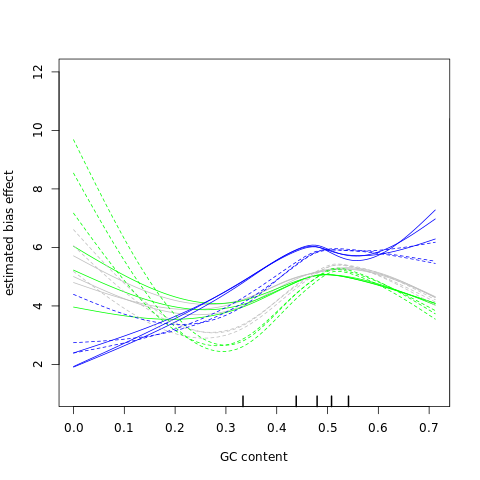

In [24]:
%%R
cqnplot <- function(x, n = 1, col = "grey60", ylab="estimated bias effect", 
                    xlab = "", type = "l", lty = 1, ...) {
    if(class(x) != "cqn")
        stop("'x' needs to be of class 'cqn'")
    if(n == 1) {
        func <- x$func1
        grid <- x$grid1
        knots <- x$knots1
    }
    if(n == 2) {
        if(is.null(x$func2))
            stop("argument 'x' does not appear to have two smooth functions (component 'func2' is NULL)")
        func <- x$func2
        grid <- x$grid2
        knots <- x$knots2
    }
    
    
    #par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
    matplot(replicate(ncol(func), grid), func, ylab = ylab, xlab = xlab, type = type,
            col = col, lty = lty, ...)
    
    legend("bottomleft", legend = colnames(x$counts), inset=c(1,0),
           title="Samples", lty = lty, col = col)
    rug(knots, lwd = 2)
    invisible(x)
    
}


library(repr)
#options(repr.plot.width = 10, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=4, repr.plot.height=3)


colors <- c(
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue',
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue'
           )
lty =c(1,1,1,1,1,1,1,1,1,
       2,2,2,2,2,2,2,2,2)

#png("Figures/Figure_12.png")
#par(mfrow=c(1,2))
cqnplot(cqn.subset, col=colors,
        n = 1, xlab = "GC content", lty = lty,
        ylim = c(1,12), 
        

       )
#dev.off()

#ggsave('plot.png', width=8.27, height= 11.69) #A4 size in inches
#dev.off()

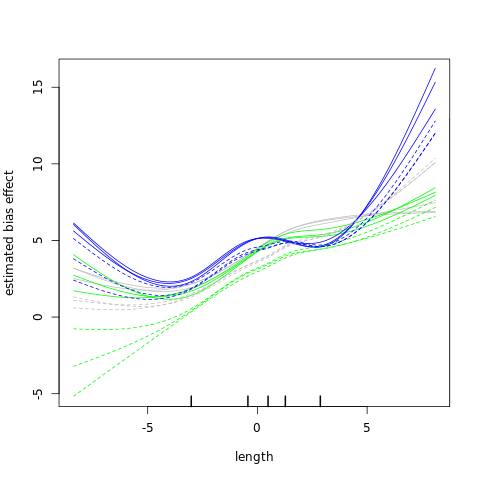

In [25]:
%%R
library(repr)
#options(repr.plot.width = 12, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=8, repr.plot.height=3)


colors <- c(
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue',
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue'
           )
lty =c(1,1,1,1,1,1,1,1,1,
       2,2,2,2,2,2,2,2,2)

#par(mfrow=c(1,2))
#png("Figures/Figure_13.png")
cqnplot(cqn.subset, col=colors,
        n = 2, xlab = "length", lty = lty,
        ylim = c(-5,16), 
    
       )
#dev.off()

### Bias Correction

In [26]:
%%R
RPKM.cqn <- cqn.subset$y + cqn.subset$offset
out_table <- RPKM.cqn
head(out_table)

              B_tot_1   B_tot_2   B_tot_3    B_pol_1    B_pol_2    B_pol_3
Tb927.8.150 -1.821603 -1.683519 -2.199373 -0.9915895 -1.2703952 -1.5563086
Tb927.8.230 -2.721957 -4.592498 -2.934779 -1.8216034 -0.9309315 -0.9309315
Tb927.8.270  3.392967  3.238313  3.085040  3.7018236  3.8355057  3.6072802
Tb927.8.320 -3.406718 -3.082770 -3.018371 -1.2703952 -0.9309315 -1.2703952
Tb927.8.370 -1.556309 -1.821603 -3.584582 -0.5004513 -1.9888980 -0.5449404
Tb927.8.443  5.157786  4.420874  4.819087  1.2060659  0.0410671  0.8788297
                B_sub_1    B_sub_2     B_sub_3     P_tot_1      P_tot_2
Tb927.8.150 -0.04502052 -0.4050868 -0.43487248 -0.65465176  0.817770414
Tb927.8.230 -0.54494037 -0.2907132  0.07651161 -0.82146041 -0.001049521
Tb927.8.270  4.15556125  4.3250622  4.15267301  3.47685383  3.249003437
Tb927.8.320  0.55017447  0.9459269  0.09415952 -0.04502052  1.151427876
Tb927.8.370 -0.40508680 -0.8716700 -0.93093155 -0.65465176 -0.405086803
Tb927.8.443  3.03064887  1.9969332  3.15174

In [27]:
#out_table

In [28]:
%R -o out_table
out_table = pd.DataFrame(out_table,index=indata.index.values,columns=indata.columns)
out_table.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.150,-1.821603,-1.683519,-2.199373,-0.991590,-1.270395,-1.556309,-0.045021,-0.405087,-0.434872,-0.654652,0.817770,0.649031,0.374009,-0.614792,0.945927,0.827619,0.969338,-0.108123
Tb927.8.230,-2.721957,-4.592498,-2.934779,-1.821603,-0.930932,-0.930932,-0.544940,-0.290713,0.076512,-0.821460,-0.001050,0.262543,0.593704,0.401678,1.137863,-0.290713,-0.654652,-3.046987
Tb927.8.270,3.392967,3.238313,3.085040,3.701824,3.835506,3.607280,4.155561,4.325062,4.152673,3.476854,3.249003,3.296550,3.909987,3.757068,3.803629,4.352354,4.223011,4.396571
Tb927.8.320,-3.406718,-3.082770,-3.018371,-1.270395,-0.930932,-1.270395,0.550174,0.945927,0.094160,-0.045021,1.151428,0.527140,1.821929,1.793915,1.137863,1.818054,2.326951,1.053690
Tb927.8.370,-1.556309,-1.821603,-3.584582,-0.500451,-1.988898,-0.544940,-0.405087,-0.871670,-0.930932,-0.654652,-0.405087,0.561210,0.387582,0.145832,0.912037,-0.694147,-0.991590,-1.988898


### Visualise Normalized Counts

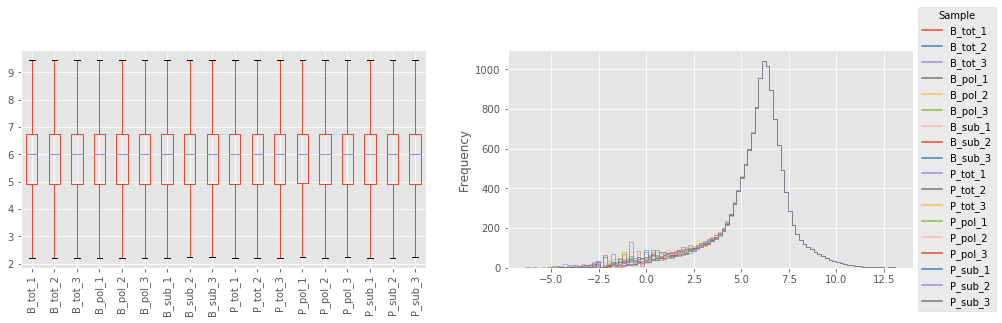

(14389, 18)


In [29]:
fig,axes=plt.subplots(figsize=(16,4),ncols=2)
ax = axes[0]
out_table.plot(kind='box',ax=ax,rot=90,showfliers=False)

ax = axes[1]
out_table.replace(-np.inf,-1.5).plot(kind='hist',
                                            histtype='step',
                                            bins=100,ax=ax)
UT.hist_legend(ax,'Sample')
#ax.set_xticklabels(out_df.columns, rotation=90, )
plt.show()
print(out_table.shape)

## Differential Expression Analysis

In [30]:
#out_table.loc['mainVSG-427-2']

In [31]:
%%R
library(edgeR)
# Make groups
design_with_all <- model.matrix( ~0+group )

y <- DGEList(counts=indata, 
                  lib.size = sizeFactors,
                  group = group, 
                  )

y$offset <- cqn.subset$glm.offset
# Estimate dispersion
y <- estimateGLMCommonDisp( y, design_with_all )
y <- estimateGLMTrendedDisp( y, design_with_all )
y <- estimateGLMTagwiseDisp( y, design_with_all )
# Fit counts to model
fit_all <- glmFit( y, design_with_all )
contrast_Bpol_v_Bsub <- glmLRT( fit_all, contrast=makeContrasts( groupBpol-groupBsub,
                                                                levels=design_with_all ) )

table_Bpol_v_Bsub <- topTags(contrast_Bpol_v_Bsub, n=Inf, 
                             sort.by = "none", adjust.method="BH")$table
topTags( contrast_Bpol_v_Bsub, n=5 )
head(table_Bpol_v_Bsub)

                 logFC     logCPM         LR       PValue          FDR
Tb927.8.150 -1.0063015 -0.5119670  6.1017140 1.350508e-02 1.762742e-02
Tb927.8.230 -1.1477417 -2.6243855  4.5228092 3.344587e-02 4.194654e-02
Tb927.8.270 -0.4956741  4.1321009 17.7185534 2.561164e-05 4.086558e-05
Tb927.8.320 -1.7809910 -0.4844270 20.6049775 5.644916e-06 9.386882e-06
Tb927.8.370 -0.2633837 -2.5063242  0.2480235 6.184702e-01 6.471181e-01
Tb927.8.443 -2.2558921  0.7747052 29.4891138 5.623166e-08 1.050547e-07


In [32]:
%%R
contrast_Ppol_v_Psub <- glmLRT( fit_all, contrast=makeContrasts(groupPpol-groupPsub,
                                                                levels=design_with_all ) )

table_Ppol_v_Psub <- topTags(contrast_Ppol_v_Psub, n=Inf, sort.by = "none", adjust.method="BH")$table
topTags( contrast_Ppol_v_Psub, n=5 )

Coefficient:  1*groupPpol -1*groupPsub 
                   logFC   logCPM       LR        PValue           FDR
Tb927.10.1570   2.998888 5.876790 1500.040  0.000000e+00  0.000000e+00
KS17gene_2065a -3.600648 6.568096 1366.373 4.262655e-299 3.066767e-295
Tb927.11.6565  -3.267078 5.412596 1353.433 2.764562e-296 1.325976e-292
KS17gene_6722a -3.371283 6.593129 1264.222 6.736298e-277 2.423215e-273
KS17gene_4624a -2.909238 5.657980 1216.990 1.238394e-266 3.563849e-263


In [33]:
#desc_dict

In [34]:
%R -o table_Ppol_v_Psub
table_Ppol_v_Psub['log_PValue'] = -np.log10(table_Ppol_v_Psub['PValue'])
table_Ppol_v_Psub['log_FDR'] = -np.log10(table_Ppol_v_Psub['FDR'])
table_Ppol_v_Psub['desc']=[desc_dict.get(n,'none') for n in table_Ppol_v_Psub.index.values]
table_Ppol_v_Psub.to_csv('Tables/Table_5.csv')
table_Ppol_v_Psub.head()

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,desc
Tb927.8.150,-0.224251,-0.511967,0.266132,0.605938,0.647039,0.217571,0.189070,variant surface glycoprotein degenerate
Tb927.8.230,5.234409,-2.624385,3.444089,0.063478,0.081699,1.197374,1.087785,expression site-associated gene 3 (ESAG3) deg...
Tb927.8.270,-0.504258,4.132101,16.600961,0.000046,0.000081,4.336039,4.089539,variant surface glycoprotein degenerate
Tb927.8.320,-0.236039,-0.484427,0.387210,0.533769,0.577996,0.272646,0.238075,variant surface glycoprotein degenerate
Tb927.8.370,1.967724,-2.506324,0.943525,0.331373,0.377136,0.479683,0.423502,expression site-associated gene 3 (ESAG3) deg...


In [35]:
%R -o table_Bpol_v_Bsub
table_Bpol_v_Bsub.head()
table_Bpol_v_Bsub['log_PValue'] = -np.log10(table_Bpol_v_Bsub['PValue'])
table_Bpol_v_Bsub['log_FDR'] = -np.log10(table_Bpol_v_Bsub['FDR'])

In [36]:
table_Bpol_v_Bsub['desc']=[desc_dict.get(n,'none') for n in table_Bpol_v_Bsub.index.values]
table_Bpol_v_Bsub.head()

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,desc
Tb927.8.150,-1.006301,-0.511967,6.101714,0.013505,0.017627,1.869503,1.753811,variant surface glycoprotein degenerate
Tb927.8.230,-1.147742,-2.624385,4.522809,0.033446,0.041947,1.475657,1.377304,expression site-associated gene 3 (ESAG3) deg...
Tb927.8.270,-0.495674,4.132101,17.718553,0.000026,0.000041,4.591563,4.388642,variant surface glycoprotein degenerate
Tb927.8.320,-1.780991,-0.484427,20.604977,0.000006,0.000009,5.248343,5.027479,variant surface glycoprotein degenerate
Tb927.8.370,-0.263384,-2.506324,0.248024,0.618470,0.647118,0.208681,0.189016,expression site-associated gene 3 (ESAG3) deg...


In [37]:
table_Bpol_v_Bsub.to_csv('Tables/Table_4.csv')

### Grumpy

In [38]:
ks_lncRNA = open('InData/GS_gene_list.txt').read().split('\n')
def grampy_VolcanoPlot(table,title,ax=False,ksgene='KS17gene_3137a',xlims=False):
    plt.style.use('ggplot')
    if not ax:
        fig,ax=plt.subplots(figsize=(12,6))
    ax.set_title(title)
    
    table.plot(x='logFC',y='log_FDR',kind='scatter',s=5,alpha=0.2,ax=ax,c='black',label='the rest')
    
    temp = [n for n in ks_lncRNA if n in table.index.values]
    table.loc[temp].plot(x='logFC',y='log_FDR',kind='scatter',s=10,alpha=1,c='b',ax=ax,
                              label='lncRNA')
    
    
    table.loc[[ksgene]].plot(y='log_FDR',x='logFC',kind='scatter',ax=ax,s=50, alpha=1
                                                   ,c='r',label='Grumpy')
    
    lgnd= ax.legend()
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[2]._sizes = [20]
    if xlims:
        ax.set_xlim(xlims[0],xlims[1])

def grampy_MAplot(table,title,ksgene='KS17gene_3137a'):
    plt.style.use('ggplot')
    fig,ax=plt.subplots(figsize=(12,6))
    ax.set_title(title)
    table.plot(x='logCPM',y='logFC',kind='scatter',s=5,alpha=0.2,ax=ax,c='black',label='the rest')
    temp = [n for n in ks_lncRNA if n in table.index.values]
    table.loc[temp].plot(x='logCPM',y='logFC',kind='scatter',s=10,alpha=1,c='b',ax=ax,
                             label='lncRNA')
    table.loc[[ksgene]].plot(y='logFC',x='logCPM',kind='scatter',ax=ax,s=50, alpha=1
                                                   ,c='r',label='Grumpy')
    lgnd= ax.legend()
    for i,n in enumerate(lgnd.legendHandles):
        n._sizes = [20]

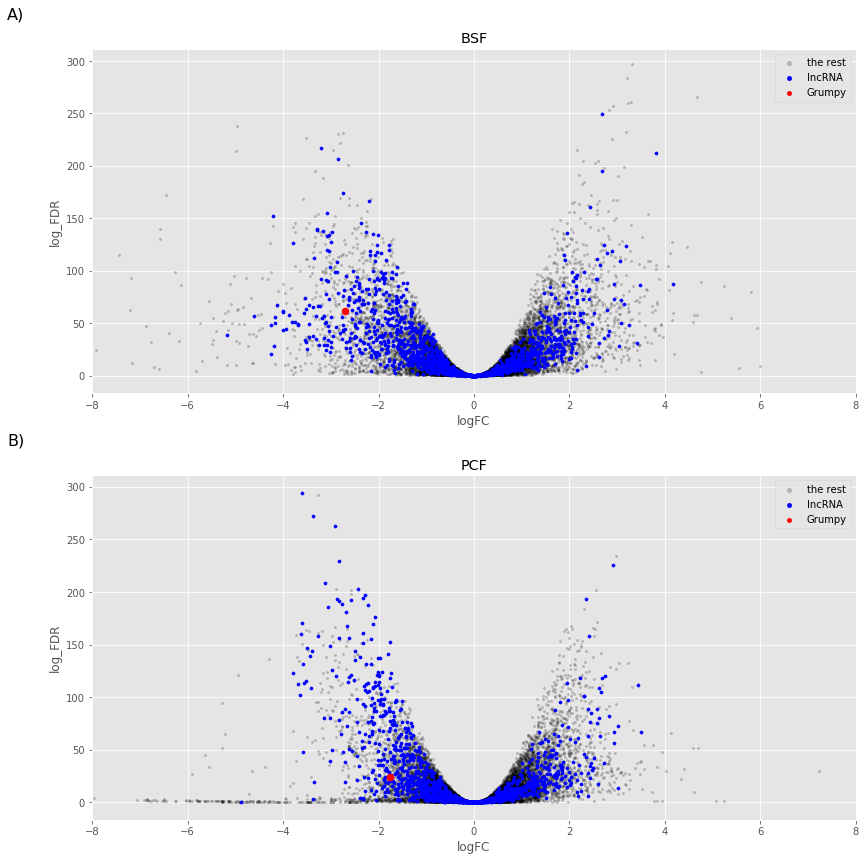

In [39]:
fig,axes=plt.subplots(figsize=(12,12),nrows=2)
grampy_VolcanoPlot(table_Bpol_v_Bsub,'BSF',axes[0],xlims=(-8,8))
grampy_VolcanoPlot(table_Ppol_v_Psub,'PCF',axes[1],xlims=(-8,8))
UT.set_fig_label(axes[0],'A')
UT.set_fig_label(axes[1],'B')
plt.tight_layout()
plt.savefig('Figures/Figure_13.png')

### average subpolysome/polysome

In [40]:
%%R
contrast_pol_v_sub <- glmLRT( fit_all, contrast=makeContrasts((groupPsub+groupBsub)/2-(groupPpol+groupBpol)/2,
                                                                levels=design_with_all ) )

table_pol_v_sub <- topTags(contrast_pol_v_sub, n=Inf, sort.by = "none", adjust.method="BH")$table
topTags( contrast_pol_v_sub, n=20 )
#head(contrast_pol_v_sub)

Coefficient:  -0.5*groupBpol 0.5*groupBsub -0.5*groupPpol 0.5*groupPsub 
                   logFC   logCPM       LR PValue FDR
MSTRG.789      -3.830780 7.002021 1791.664      0   0
KS17gene_34a    3.348232 6.526367 1507.088      0   0
KS17gene_2065a  3.225271 6.568096 2313.932      0   0
Tb927.10.6060  -3.108763 5.966929 2290.571      0   0
Tb927.4.3870    3.064866 6.477057 1601.333      0   0
Tb927.11.6565   3.040987 5.412596 2373.344      0   0
KS17gene_2098a  3.011462 6.013919 1716.164      0   0
KS17gene_3178a  3.003674 5.993071 1954.435      0   0
Tb927.10.15040  2.975620 6.368807 1565.683      0   0
Tb927.8.6240   -2.822596 7.034526 1850.122      0   0
KS17gene_6722a  2.814671 6.593129 1862.426      0   0
KS17gene_3335a -2.799011 6.352484 1949.609      0   0
Tb927.4.3060   -2.758708 6.077982 2006.481      0   0
TRY.574        -2.710584 5.961843 1590.357      0   0
TRY.222        -2.659231 6.236804 1871.854      0   0
Tb927.10.1570  -2.654438 5.876790 2312.076      0   0
Tb927.3.5

In [41]:
%R -o table_pol_v_sub
table_pol_v_sub.head()
table_pol_v_sub['log_PValue'] = -np.log10(table_pol_v_sub['PValue'])
table_pol_v_sub['log_FDR'] = -np.log10(table_pol_v_sub['FDR'])


In [42]:
#table_pol_v_sub.loc['KS17gene_1749a']

## ANOVA Like

In [43]:
%%R
design_anova <- model.matrix(~group, data=y$samples)
fit <- glmQLFit(y, design_anova)
qlf <- glmQLFTest(fit, coef=2:6)
anova_like <- topTags(qlf, n=Inf, sort.by = "none", adjust.method="BH")$table
head(anova_like)

            logFC.groupBsub logFC.groupBtot logFC.groupPpol logFC.groupPsub
Tb927.8.150        1.006703      -0.5778156       1.6128030       1.8081061
Tb927.8.230        1.147913      -2.1132543       0.2543062      -4.9796432
Tb927.8.270        0.495641      -0.4720031       0.1040657       0.6082262
Tb927.8.320        1.778967      -1.9622128       2.7941234       3.0226490
Tb927.8.370        0.263617      -1.3022661      -0.3657731      -2.3322396
Tb927.8.443        2.257926       4.2730822       1.0976309       2.5903698
            logFC.groupPtot     logCPM         F       PValue          FDR
Tb927.8.150       1.5681051 -0.5119670 11.492009 7.588633e-05 8.344249e-05
Tb927.8.230      -0.9151880 -2.6243855  9.668199 3.620073e-04 3.862181e-04
Tb927.8.270      -0.3717965  4.1321009 42.112732 1.122724e-08 1.735963e-08
Tb927.8.320       1.7265159 -0.4844270 45.566899 6.267270e-09 1.006470e-08
Tb927.8.370      -0.2220656 -2.5063242  2.757563 5.536492e-02 5.602685e-02
Tb927.8.443       

In [44]:
%R -o anova_like
anova_like=anova_like[['F', 'PValue', 'FDR']]
anova_threshold = 1e-2
anova_like.shape,anova_like[anova_like['FDR']<anova_threshold].shape

((14389, 3), (14021, 3))

In [45]:
out_table.shape

(14389, 18)

In [46]:
#%%R
#library(HybridMTest)
#computed but not used for now
#anova_test <- row.oneway.anova(cpm_df, group)
#FDR1 <- p.adjust(anova_test$pval, "bonferroni")

In [47]:
#%R -o cpm_df,anova_test,FDR1,tt_Bsub_Bpol

In [48]:
#%R length(FDR1[FDR1 < 0.01])

In [49]:
out_df = out_table.copy()

In [50]:
out_df.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.150,-1.821603,-1.683519,-2.199373,-0.991590,-1.270395,-1.556309,-0.045021,-0.405087,-0.434872,-0.654652,0.817770,0.649031,0.374009,-0.614792,0.945927,0.827619,0.969338,-0.108123
Tb927.8.230,-2.721957,-4.592498,-2.934779,-1.821603,-0.930932,-0.930932,-0.544940,-0.290713,0.076512,-0.821460,-0.001050,0.262543,0.593704,0.401678,1.137863,-0.290713,-0.654652,-3.046987
Tb927.8.270,3.392967,3.238313,3.085040,3.701824,3.835506,3.607280,4.155561,4.325062,4.152673,3.476854,3.249003,3.296550,3.909987,3.757068,3.803629,4.352354,4.223011,4.396571
Tb927.8.320,-3.406718,-3.082770,-3.018371,-1.270395,-0.930932,-1.270395,0.550174,0.945927,0.094160,-0.045021,1.151428,0.527140,1.821929,1.793915,1.137863,1.818054,2.326951,1.053690
Tb927.8.370,-1.556309,-1.821603,-3.584582,-0.500451,-1.988898,-0.544940,-0.405087,-0.871670,-0.930932,-0.654652,-0.405087,0.561210,0.387582,0.145832,0.912037,-0.694147,-0.991590,-1.988898


## RadViz - Signature in BSF SUB

In [51]:
#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

#from cqn These values are on the log2scale.        
radviz_dataset = np.exp(out_df).copy()

radviz_dataset=radviz_dataset[anova_like['FDR']<anova_threshold]
cols = list(radviz_dataset.columns)
#group coluns in cunk of 3 to compute the mean
col_grups = chunks(cols, 3)
for g in col_grups:
    base = '_'.join(g[0].split('_')[0:2])
    radviz_dataset[base]=radviz_dataset[g].median(axis=1)

#assign each gene to the class with max count

classes = radviz_dataset.iloc[:,18:].idxmax(axis=1)
#replace = {'B_pol':0, 'B_sub':1, 'B_tot':2, 'P_pol':3, 'P_sub':4, 'P_tot':5}
#classes = classes.replace(replace)
radviz_dataset=radviz_dataset.iloc[:,18:]
radviz_dataset['classes']=classes
radviz_dataset.head()

,B_tot,B_pol,B_sub,P_tot,P_pol,P_sub,classes
Tb927.8.150,0.161766,0.280721,0.666919,1.913685,1.453550,2.287864,P_sub
Tb927.8.230,0.053142,0.394186,0.747730,0.998951,1.810682,0.519623,P_pol
Tb927.8.270,25.490677,40.521132,63.787756,27.019272,44.863709,77.661098,P_sub
Tb927.8.320,0.045832,0.280721,1.733555,1.694080,6.012950,6.159858,P_sub
Tb927.8.443,123.851995,2.408080,20.710667,116.487234,6.256406,20.505266,B_tot


In [52]:
radviz_dataset.shape

(14021, 7)

### RadViz figure

B_sub
P_pol
P_tot
P_sub
B_pol
B_tot
column_names ['B_tot', 'P_tot', 'B_sub', 'P_sub', 'B_pol', 'P_pol']


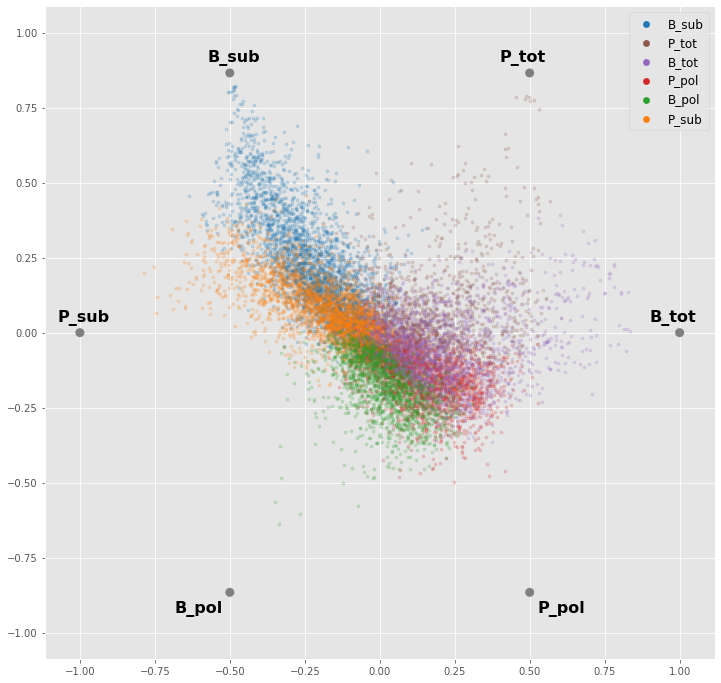

In [55]:
fig,ax=plt.subplots(figsize=(12,12))
cols = [n for n in out_df.columns if n.endswith('_mean')]
color = {'B_tot':'tab:purple','B_pol':'tab:green','B_sub':'tab:blue',
         'P_tot':'tab:brown','P_pol':'tab:red','P_sub':'tab:orange'}

radviz_dataset=radviz_dataset[['B_tot','P_tot','B_sub','P_sub','B_pol','P_pol','classes']]
rad_viz,to_plot,s = UT.radviz(radviz_dataset, 
                           'classes', color=color,ax=ax, legend_order = [
                             'B_sub', 'P_tot' , 'B_tot', 'P_pol','B_pol','P_sub'
                           ])
plt.savefig('Figures/Figure_8.png')

## Cluster analysis

In [56]:
#mydata = out_df.iloc[:,:18]
#min_values = []
#for col in mydata:
#    min_values.append(mydata[col][mydata[col]>0].min())
#min_values
#del mydata


cluster_dataset=np.exp(out_df.iloc[:,:18])#+min_values
cluster_dataset.head()
cluster_dataset.describe()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
count,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000,14389.000000
mean,1433.172853,1433.113998,1433.147906,1433.231071,1433.231141,1433.227224,1433.467453,1433.556144,1433.579077,1433.417936,1433.585054,1433.574803,1433.777286,1433.726640,1433.681031,1433.558262,1433.573472,1433.437061
std,8205.650797,8205.660467,8205.654829,8205.640652,8205.640562,8205.641342,8205.601606,8205.587353,8205.583733,8205.609390,8205.580648,8205.582645,8205.549311,8205.557487,8205.564612,8205.586164,8205.583764,8205.607590
min,0.001745,0.008992,0.004096,0.009397,0.005404,0.026017,0.014199,0.011862,0.006644,0.011128,0.054649,0.069657,0.064378,0.057715,0.066014,0.067034,0.065792,0.007642
25%,138.305732,138.305732,138.305732,138.374279,138.374279,138.374279,138.817739,139.084198,139.017962,138.755824,138.755824,138.755824,139.268017,138.887587,138.949078,138.755824,138.691770,139.017962
50%,410.670524,410.670524,410.670524,410.670524,410.670524,410.670524,410.670524,410.670524,410.764530,410.670524,410.670524,410.670524,410.764530,410.764530,410.670524,410.670524,410.764530,410.670524
75%,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704,843.307704
max,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862,489629.160862


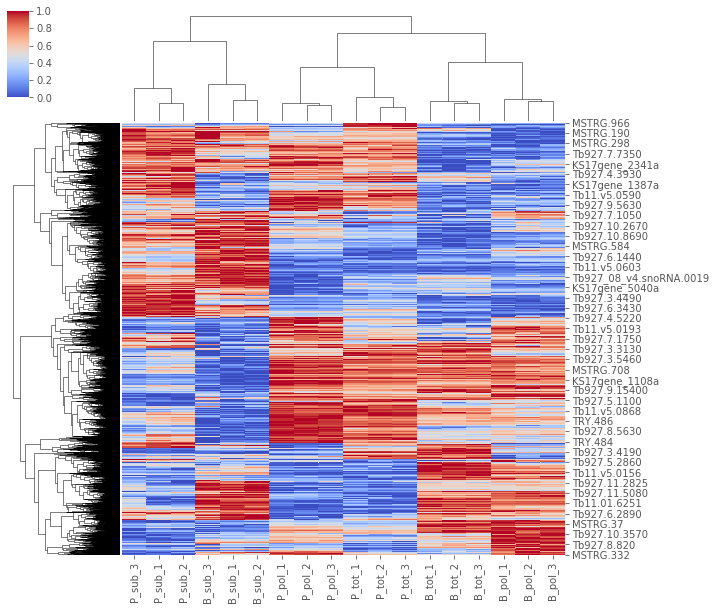

In [57]:
#%R -o anova_test,FDR
cluster_dataset=out_df.iloc[:,:18]
clustergrid = sns.clustermap(cluster_dataset[anova_like['FDR']<anova_threshold].sample(frac=0.3),
                             cmap=sns.color_palette("coolwarm", 256), 
                             standard_scale=0)


### Number of clusters

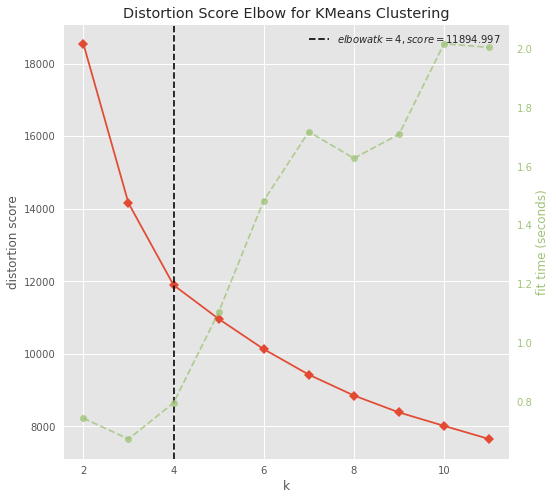

In [58]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
plt.style.use('ggplot')
X = UT.standard_scale(cluster_dataset[anova_like['FDR']<anova_threshold],0)
# Instantiate the clustering model and visualizer
model = KMeans()
fig, ax = plt.subplots(figsize=(8,8)) 
visualizer = KElbowVisualizer(model, k=(2,12),ax=ax)

visualizer.fit(X.values)        # Fit the data to the visualizer


visualizer.show(outpath="Figures/Figure_9.png")
#visualizer.show()


In [59]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
pd.Series(kmeans.labels_).value_counts()

1    4354
3    3528
0    3269
2    2869
dtype: int64

In [60]:
#from sklearn.cluster import SpectralBiclustering

#clustering = SpectralBiclustering(n_clusters=5,
#assign_labels="discretize",
#random_state=0).fit(X)
#pd.Series(clustering.labels_).value_counts()

### Cluster figure

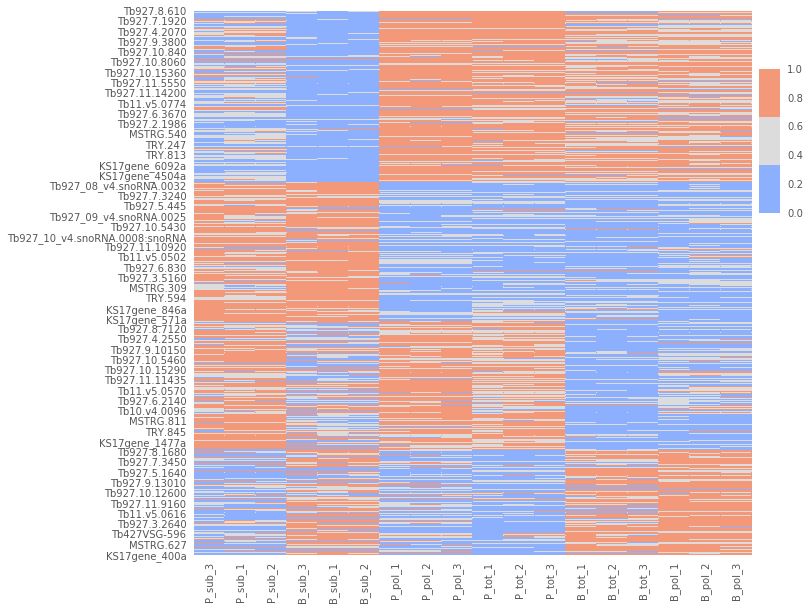

In [61]:
#res = TDdf[anova_test['FDR']<0.01]
X['label']=kmeans.labels_+1
#X['label']=X['label'].replace(dict_replace)
order = pd.Series(kmeans.labels_).value_counts().index.values

list_df = []
for n in order:
    list_df.append(X[X['label']==n+1])

final_list_df = []
for index,temp_df in enumerate(list_df):
    temp_df['label']=index+1
    final_list_df.append(temp_df)
    

X = pd.concat(final_list_df)


fig, ax = plt.subplots(figsize=(10,10))  
cbar_ax = fig.add_axes([.91, .6, .03, .2])
# Sample figsize in inches




sns.heatmap(X.iloc[:,0:-1].T.iloc[
    clustergrid.dendrogram_col.reordered_ind].T.astype(float),
            cmap=sns.color_palette("coolwarm", 3),
           ax=ax, cbar_ax = cbar_ax, cbar=True)

plt.savefig('Figures/Figure_10.png')

In [62]:
ks_lncRNA = open('InData/GS_gene_list.txt').read().split('\n')
X['is_ks']=[1 if n in ks_lncRNA else 0 for n in X.index.values]
len(ks_lncRNA)
X['is_ks'].value_counts()

0    12607
1     1413
Name: is_ks, dtype: int64

### Table lncRNA enrichment in clusters 


In [63]:
from scipy import stats


#k = np.arange(5)
#N = 52 # population size
#G = 4  # number of good elements in population
#n = 5  # simple random sample size
#stats.hypergeom.pmf(k, N, G, n)

population_size = X.shape[0]

for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['is_ks']==1) ].shape[0]
    population_sucess = X[X['is_ks']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=2.58e-03
_________
cluster 2: enrichment pvalue=3.49e-14
_________
cluster 3: enrichment pvalue=2.64e-02
_________
cluster 4: enrichment pvalue=4.89e-10
_________


### Cluster Table

In [64]:
X['desc']=[desc_dict.get(n,'none') for n in X.index.values]
X['H/ACA-like snoRNA']=[1 if 'H/ACA-like snoRNA' in n else 0 for n in X['desc']]
X['snoRNA']=[1 if 'snoRNA' in n else 0 for n in X.index.values]
X['Noncoding']=[1 if 'Noncoding RNA' in n else 0 for n in X['desc']]

### Table snoRNA

In [65]:
X.groupby('label')['snoRNA','H/ACA-like snoRNA','is_ks'].sum()

,snoRNA,H/ACA-like snoRNA,is_ks
label,,,
1,17,5,404
2,182,44,473
3,63,11,330
4,20,6,206


In [66]:
X.to_csv('Tables/Table_1.csv')

In [67]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['H/ACA-like snoRNA']==1) ].shape[0]
    population_sucess = X[X['H/ACA-like snoRNA']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=3.50e-06
_________
cluster 2: enrichment pvalue=1.16e-12
_________
cluster 3: enrichment pvalue=5.41e-02
_________
cluster 4: enrichment pvalue=7.14e-03
_________


In [68]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['snoRNA']==1) ].shape[0]
    population_sucess = X[X['snoRNA']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=1.24e-25
_________
cluster 2: enrichment pvalue=4.50e-45
_________
cluster 3: enrichment pvalue=5.32e-02
_________
cluster 4: enrichment pvalue=2.25e-10
_________


In [69]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['Noncoding']==1) ].shape[0]
    population_sucess = X[X['Noncoding']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=4.89e-06
_________
cluster 2: enrichment pvalue=1.47e-03
_________
cluster 3: enrichment pvalue=3.24e-07
_________
cluster 4: enrichment pvalue=1.85e-06
_________


## GO term Analysis

In [70]:
from goatools.base import download_go_basic_obo
from goatools.associations import read_associations
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag
from goatools.associations import read_gaf

### Fix gaf file

In [71]:
import tqdm
replace_dict = {'P':'BP','F':'MF','C':'CC'}
def pars_trytripDB_gaf(infile):
    new_file = open(infile.replace('.gaf','2.gaf'),'w')
    for l in tqdm.tqdm(open(infile)):
        if l.startswith('!'):
            #new_file.write(l)
            continue
        else:    
            temp_list = l.split('\t')
            code = l.split('\t')[8]
            if code not in  replace_dict:
                continue
            temp_list[8] = replace_dict[code]
            new_file.write(temp_list[1]+'\t'+temp_list[4]+'\n')
    new_file.close()

pars_trytripDB_gaf('InData/TriTrypDB-46_TbruceiTREU927_GO.gaf')    

36000it [00:00, 137123.90it/s]


In [72]:
obo_fname = download_go_basic_obo()
in_go=os.path.join('InData/go-basic.obo')
obodag = GODag(in_go)
geneid2gos = read_associations('InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf')

  EXISTS: go-basic.obo
InData/go-basic.obo: fmt(1.2) rel(2020-06-01) 47,233 GO Terms
HMS:0:00:00.163627  26,294 annotations READ: InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf 
**ERROR IdToGosReader(..., godag=None).get_id2gos: GODAG is None. IGNORING namespace(BP)

7683 IDs in all associations

In [73]:
out_df.shape,X.shape

((14389, 18), (14020, 24))

In [74]:
all_genes = out_df.index.values
print(len(all_genes))
goeaobj = GOEnrichmentStudy(
            list(all_genes), # List of mouse protein-coding genes
            geneid2gos, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh'])

14389

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 51%  7,348 of 14,389 population items found in association


In [75]:
all_res = []
def analysis(data, cluster_id=0):
    geneids_study =  list(data[(data['label']==cluster_id)].index.values)
    geneids_study = [n for n in geneids_study if n in all_genes]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.01]
    for item in goea_results_sig:
        item_list = str(item).split('\t')
        #print(item_list)
        tempres = [str(cluster_id), item_list[0], str(item_list[6]), item_list[1], item_list[3], item_list[4]]
        all_res.append('\t'.join(tempres))

for n in [1,2,3,4]:
    print(n,'_________________')
    analysis(X, cluster_id=n)

print(len(all_res))    
go_term_res = open('InData/goterm_enrich.txt','w')
go_term_res.write('\n'.join(all_res))
go_term_res.close()

1 _________________

Run GOEA Gene Ontology Analysis: current study set of 4354 IDs ... 57%  2,483 of  4,354 study items found in association
100%  4,354 of  4,354 study items found in population(14389)
Calculating 1,947 uncorrected p-values using fisher_scipy_stats
   1,947 GO terms are associated with  7,348 of 14,389 population items
   1,248 GO terms are associated with  2,483 of  4,354 study items
  METHOD fdr_bh:
      74 GO terms found significant (< 0.05=alpha) ( 62 enriched +  12 purified): statsmodels fdr_bh
   2,112 study items associated with significant GO IDs (enriched)
     126 study items associated with significant GO IDs (purified)
2 _________________

Run GOEA Gene Ontology Analysis: current study set of 3528 IDs ... 47%  1,668 of  3,528 study items found in association
100%  3,528 of  3,528 study items found in population(14389)
Calculating 1,947 uncorrected p-values using fisher_scipy_stats
   1,947 GO terms are associated with  7,348 of 14,389 population items
   

In [76]:
#pd.read_csv??

In [77]:
go_terms = pd.read_csv('InData/goterm_enrich.txt', sep='\t', header=None)
go_terms.columns = ['clusterID','goID','pvalue','goType','goDesc','found']
go_terms['found']=[int(n.split('/')[0]) for n in go_terms['found']]
go_terms['clusterID'] = ['C'+str(n) for n in go_terms['clusterID']]
print(go_terms.shape)
go_terms = go_terms[go_terms['found']>=2]
print(go_terms.shape)
del go_terms['found']
go_terms.head()

(61, 6)
(61, 6)


,clusterID,goID,pvalue,goType,goDesc
0,C1,GO:0051603,1.900000e-09,BP,proteolysis involved in cellular protein catab...
1,C1,GO:0010608,2.920000e-09,BP,posttranscriptional regulation of gene expression
2,C1,GO:0006950,5.320000e-08,BP,response to stress
3,C1,GO:0007018,8.070000e-07,BP,microtubule-based movement
4,C1,GO:0006511,4.860000e-06,BP,ubiquitin-dependent protein catabolic process


In [78]:
go_terms['clusterID'].value_counts()

C1    46
C4     8
C3     6
C2     1
Name: clusterID, dtype: int64

In [79]:
unique_go = go_terms.goID.value_counts()[go_terms.goID.value_counts()<=3].index.values
go_terms = go_terms[go_terms.goID.isin(unique_go)]
go_terms.head()

,clusterID,goID,pvalue,goType,goDesc
0,C1,GO:0051603,1.900000e-09,BP,proteolysis involved in cellular protein catab...
1,C1,GO:0010608,2.920000e-09,BP,posttranscriptional regulation of gene expression
2,C1,GO:0006950,5.320000e-08,BP,response to stress
3,C1,GO:0007018,8.070000e-07,BP,microtubule-based movement
4,C1,GO:0006511,4.860000e-06,BP,ubiquitin-dependent protein catabolic process


In [80]:
go_terms['clusterID'].value_counts()

C1    46
C4     8
C3     6
C2     1
Name: clusterID, dtype: int64

In [81]:
go_terms = go_terms[go_terms['clusterID']!='C1']

In [82]:
#vizGo = pd.pivot_table(go_terms, index='goID',columns['clusterID'])#.reset_index()
vizGo = pd.pivot_table(go_terms, index='goDesc', columns=['clusterID'])
vizGo = -np.log10(vizGo)
vizGo=vizGo.fillna(0)
print(vizGo.head())
vizGo.columns = ['C2','C3','C4']
vizGo =vizGo.sort_values(['C2','C3','C4'])
vizGo.head()

                                              pvalue                    
clusterID                                         C2        C3        C4
goDesc                                                                  
S-adenosylmethionine biosynthetic process   0.000000  0.000000  6.307153
cell surface                                0.000000  0.000000  5.612610
evasion of host immune response             0.000000  6.446117  0.000000
integral component of membrane              0.000000  0.000000  8.525784
mRNA binding                               11.920819  0.000000  0.000000


,C2,C3,C4
goDesc,,,
cell surface,0.0,0.000000,5.612610
S-adenosylmethionine biosynthetic process,0.0,0.000000,6.307153
methionine adenosyltransferase activity,0.0,0.000000,6.307153
integral component of membrane,0.0,0.000000,8.525784
translation,0.0,5.294136,5.782516


In [83]:
vizGo.tail()

,C2,C3,C4
goDesc,,,
evasion of host immune response,0.000000,6.446117,0.000000
ribosome,0.000000,7.363512,5.673664
structural constituent of ribosome,0.000000,7.559091,6.405607
mitochondrion,0.000000,10.759451,5.329754
mRNA binding,11.920819,0.000000,0.000000


### GO term Figure

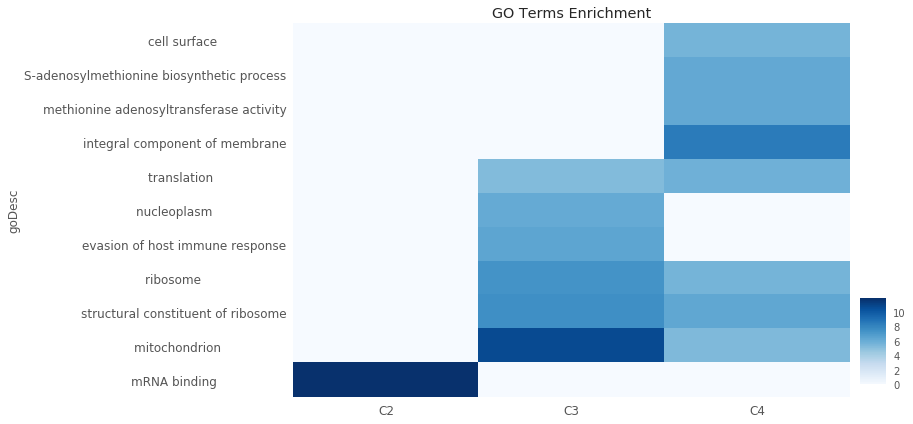

In [84]:
#del vizGo['C1']
fig, ax = plt.subplots(figsize=(12,6))  
cbar_ax = fig.add_axes([1, .1, .03, .2])
# Sample figsize in inches
sns.heatmap(vizGo,
            cmap=sns.color_palette("Blues", 128),
           ax=ax, cbar_ax = cbar_ax, cbar=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('GO Terms Enrichment')
print(ax.get_ylim())
ax.set_ylim(ax.get_ylim()[0]+0.5, 0)
plt.tight_layout()
plt.savefig('Figures/Figure_11.png')
plt.show()

## mRNA Half Life

In [85]:
pcf_hl = pd.read_csv('InData/mRNA_Half_Life/mrnaPCFhl.txt',sep='\t',index_col=[0])
bsf_hl = pd.read_csv('InData/mRNA_Half_Life/mrnaBSFhl.txt',sep='\t',index_col=[0])
hl = pcf_hl.join(bsf_hl,how='outer')
hl=hl.reset_index()
hl_lookup = pd.read_csv('InData/mRNA_Half_Life//mRNAhl_lookup.txt',sep='\t',index_col=[0])
hl_df = hl_lookup.merge(hl,left_on='Input ID',right_on='Gene_ID',how='outer')
hl_df.set_index('Gene_ID',inplace=True)
hl_df=hl_df.join(X,how='left')
del hl_df['Unnamed: 6']
#hl_df['hl_dif']=hl_df['BSF_half-life']/hl_df['PCF_half-life']
hl_df.head()

,Organism,Genomic Location (Gene),Product Description,Gene Type,Input ID,PCF_half-life,BSF_half-life,B_tot_1,B_tot_2,B_tot_3,...,P_pol_3,P_sub_1,P_sub_2,P_sub_3,label,is_ks,desc,H/ACA-like snoRNA,snoRNA,Noncoding
Tb927.1.1020,T. brucei brucei TREU927,"Tb927_01_v5.1:294,104..296,172(+)",leucine-rich repeat-containing protein,protein coding,Tb927.1.1020,10.0,13.62,0.017183,0.000000,0.181118,...,0.818762,0.697112,0.710453,1.000000,3.0,0.0,leucine-rich repeat-containing protein,0.0,0.0,0.0
Tb927.1.1030,T. brucei brucei TREU927,"Tb927_01_v5.1:296,918..298,629(+)",Nucleolar protein 49,protein coding,Tb927.1.1030,10.0,7.91,0.000000,0.027551,0.064138,...,0.326389,0.625057,0.661918,0.709293,2.0,0.0,Nucleolar protein 49,0.0,0.0,0.0
Tb927.1.1040,NaN,NaN,NaN,NaN,NaN,NaN,6.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.1.1080,T. brucei brucei TREU927,"Tb927_01_v5.1:305,834..307,362(+)","TFIIH basal transcription factor subunit, puta...",protein coding,Tb927.1.1080,7.0,7.38,0.810764,0.579211,0.595761,...,0.176855,0.955491,0.918993,1.000000,2.0,0.0,TFIIH basal transcription factor subunit puta...,0.0,0.0,0.0
Tb927.1.1120,T. brucei brucei TREU927,"Tb927_01_v5.1:312,383..313,566(+)","ribosomal RNA-processing protein 8, putative",protein coding,Tb927.1.1120,10.0,8.97,0.274445,0.139208,0.232743,...,0.903318,0.633097,0.621679,0.550814,3.0,0.0,ribosomal RNA-processing protein 8 putative,0.0,0.0,0.0


In [86]:
#for col in ['PCF_half-life','BSF_half-life']:
#    col_zscore = col + '_zscore'
#    hl_df[col_zscore] =((hl_df[col] - hl_df[col].mean())/hl_df[col].std(ddof=0)).values

#hl_df['hl_dif_zscore']=hl_df['BSF_half-life_zscore']-hl_df['PCF_half-life_zscore']    
#hl_df.groupby('label')[['PCF_half-life_zscore','BSF_half-life_zscore','hl_dif_zscore']].mean()

### Table mRNA half life

In [87]:
hl_df['hl_dif']=hl_df['BSF_half-life']/hl_df['PCF_half-life']    
hl_df.groupby('label')[['PCF_half-life','BSF_half-life','hl_dif']].median().sort_values('hl_dif')

,PCF_half-life,BSF_half-life,hl_dif
label,,,
1.0,27.0,14.39,0.490790
3.0,20.5,10.86,0.492222
2.0,15.0,10.55,0.633750
4.0,17.0,11.37,0.646000


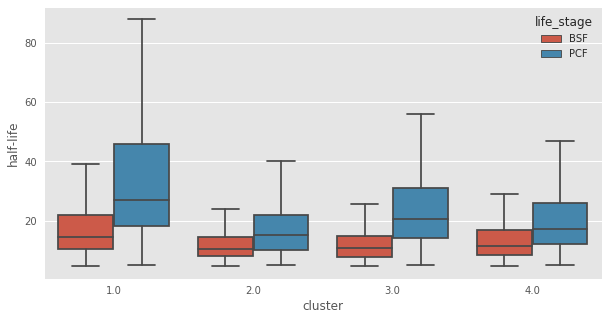

In [88]:
temp1 = hl_df[['BSF_half-life','label']]
temp1.columns = ['half-life','cluster']
temp1['life_stage']='BSF'
temp2 = hl_df[['PCF_half-life','label']]
temp2.columns = ['half-life','cluster']
temp2['life_stage']='PCF'
dataset_hl = pd.concat([temp1,temp2])

fig, ax = plt.subplots(figsize=(10,5))  
sns.boxplot(data=dataset_hl,x='cluster',
            y='half-life',hue='life_stage',
            showfliers=False,ax=ax)
plt.savefig('Figures/Figure_12.png')
plt.show()

In [89]:
dataset_hl.groupby(['cluster','life_stage'])['half-life'].mean().sort_values()

cluster  life_stage
2.0      BSF           12.351193
3.0      BSF           13.009211
4.0      BSF           14.374877
1.0      BSF           17.925396
2.0      PCF           18.934579
4.0      PCF           21.828125
3.0      PCF           26.666290
1.0      PCF           36.649829
Name: half-life, dtype: float64

## Finding new protein coding genes

In [90]:
a=0
!gtf2bed < 'tb927_5.gtf' > 'tb927_5.bed'
!sort-bed < 'tb927_5.bed' - > 'tb927_5_sorted.bed'
outfile = open('tb927_5_sorted_filter.bed','w')
for line in open('tb927_5_sorted.bed'):
    #print(line)
    if 'KS17' in line:
        outfile.write(line)
    elif 'MSTRG' in line:
        outfile.write(line)
    elif 'TRY.' in line:
        outfile.write(line)
    else:
        a+=1
        pass
print(a)    
outfile.close()

49170


### process proteomics

In [2]:
def process_peps(infile='proteomics/CDS/peptides.zip'):
    bsf_cds_pep = pd.read_csv(infile,sep='\t', usecols=
                              ['Proteins','Reverse','Potential contaminant',
                              'Start position', 'Sequence', 'End position'])
    bsf_cds_pep['Proteins'] =bsf_cds_pep['Proteins'].astype(str)
    bsf_cds_pep['Reverse'] = bsf_cds_pep['Reverse'].astype(str)
    bsf_cds_pep = bsf_cds_pep[bsf_cds_pep['Reverse'] != '+' ]
    bsf_cds_pep['Potential contaminant'] = bsf_cds_pep['Potential contaminant'].astype(str)
    bsf_cds_pep = bsf_cds_pep[bsf_cds_pep['Potential contaminant'] != '+' ]
    del bsf_cds_pep['Potential contaminant']
    bsf_cds_pep['my_name'] = [n.split(';')[0] for n in bsf_cds_pep['Proteins']]
    bsf_cds_pep['my_chro'] = [n.split('-')[0] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_frame'] = [n.split('-')[1] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_start'] = [n.split('-')[2] for n in bsf_cds_pep['my_name']]
    bsf_cds_pep['my_end'] = [n.split('-')[3] for n in bsf_cds_pep['my_name']]

    bsf_cds_pep['my_start']=bsf_cds_pep['my_start'].astype(int)
    bsf_cds_pep['my_end']=bsf_cds_pep['my_end'].astype(int)

    bsf_cds_pep['dif'] = bsf_cds_pep['my_start']-bsf_cds_pep['my_end']
    bsf_cds_pep['new_start'] = bsf_cds_pep[['my_start','my_end']].min(axis=1).astype(int)
    bsf_cds_pep['new_end'] = bsf_cds_pep[['my_start','my_end']].max(axis=1).astype(int)
    return bsf_cds_pep

bsf_cds_pep =  process_peps(infile='InData/Proteomics/peptides_bsf_trim.zip')
pcf_cds_pep = process_peps(infile='InData/Proteomics/peptides_pcf_trim.zip')

In [3]:
(586011-586068)/3

-19.0

In [4]:
bsf_cds_pep.head()
bsf_cds_pep['life_stage']='BSF'
pcf_cds_pep['life_stage']='PCF'

In [5]:
bsf_cds_pep['Proteins'].str

,Sequence,Proteins,Start position,End position,Reverse,my_name,my_chro,my_frame,my_start,my_end,dif,new_start,new_end,life_stage
0,AAAAAAAAEVESGIAGVEETLR,Tb927_05_v5.1-3-586011-591284,20.0,41.0,nan,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,3,586011,591284,-5273,586011,591284,BSF
1,AAAAAAAAEVESGIAGVEETLRR,Tb927_05_v5.1-3-586011-591284,20.0,42.0,nan,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,3,586011,591284,-5273,586011,591284,BSF
2,AAAAAFQESVGR,Tb927_08_v5.1-1-1802833-1806903,612.0,623.0,nan,Tb927_08_v5.1-1-1802833-1806903,Tb927_08_v5.1,1,1802833,1806903,-4070,1802833,1806903,BSF
3,AAAAATISGAVPMHSLQASGGHASGADDSTCER,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,426.0,458.0,nan,Tb927_11_bin_v5.1-6-1334239-1332284,Tb927_11_bin_v5.1,6,1334239,1332284,1955,1332284,1334239,BSF
4,AAAAATISGAVPMHSLQASGGHASGADDSTCERICAALK,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,426.0,464.0,nan,Tb927_11_bin_v5.1-6-1334239-1332284,Tb927_11_bin_v5.1,6,1334239,1332284,1955,1332284,1334239,BSF


In [94]:
bsf_cds_pep=pd.concat([bsf_cds_pep,pcf_cds_pep])

In [95]:
bsf_cds_pep[bsf_cds_pep['Sequence']=='YLNFGNAADFTDGYGMVIR']

,Sequence,Proteins,Start position,End position,Reverse,my_name,my_chro,my_frame,my_start,my_end,dif,new_start,new_end,life_stage
78036,YLNFGNAADFTDGYGMVIR,Tb927_02_v5.1-1-246664-247455;Tb927_11_bin_v5....,505.0,523.0,nan,Tb927_02_v5.1-1-246664-247455,Tb927_02_v5.1,1,246664,247455,-791,246664,247455,BSF
59269,YLNFGNAADFTDGYGMVIR,Tb927_11_bin_v5.1-2-3629708-3631792;Tb927_02_v...,505.0,523.0,nan,Tb927_11_bin_v5.1-2-3629708-3631792,Tb927_11_bin_v5.1,2,3629708,3631792,-2084,3629708,3631792,PCF


In [96]:
neg_dif = bsf_cds_pep[bsf_cds_pep['dif']<1]
neg_dif['pep_start'] = (neg_dif['Start position']*3)+neg_dif['my_start']-3
neg_dif['pep_end'] = neg_dif['pep_start']+(neg_dif['Sequence'].str.len() *3)-1
neg_dif.head()

,Sequence,Proteins,Start position,End position,Reverse,my_name,my_chro,my_frame,my_start,my_end,dif,new_start,new_end,life_stage,pep_start,pep_end
0,AAAAAAAAEVESGIAGVEETLR,Tb927_05_v5.1-3-586011-591284,20.0,41.0,nan,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,3,586011,591284,-5273,586011,591284,BSF,586068.0,586133.0
1,AAAAAAAAEVESGIAGVEETLRR,Tb927_05_v5.1-3-586011-591284,20.0,42.0,nan,Tb927_05_v5.1-3-586011-591284,Tb927_05_v5.1,3,586011,591284,-5273,586011,591284,BSF,586068.0,586136.0
2,AAAAAFQESVGR,Tb927_08_v5.1-1-1802833-1806903,612.0,623.0,nan,Tb927_08_v5.1-1-1802833-1806903,Tb927_08_v5.1,1,1802833,1806903,-4070,1802833,1806903,BSF,1804666.0,1804701.0
5,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK,Tb927_01_v5.1-3-717978-720599,364.0,393.0,nan,Tb927_01_v5.1-3-717978-720599,Tb927_01_v5.1,3,717978,720599,-2621,717978,720599,BSF,719067.0,719156.0
6,AAAADCAADGRLDEAVDLLAQALR,Tb927_03_v5.1-3-1499100-1500287,116.0,139.0,nan,Tb927_03_v5.1-3-1499100-1500287,Tb927_03_v5.1,3,1499100,1500287,-1187,1499100,1500287,BSF,1499445.0,1499516.0


In [97]:
pos_dif = bsf_cds_pep[bsf_cds_pep['dif']>1]
pos_dif.head()
pos_dif['pep_end'] = pos_dif['my_start'] -(pos_dif['End position']*3)+1
pos_dif['pep_start']=pos_dif['pep_end']+(pos_dif['Sequence'].str.len() *3)-1
#pos_dif['pep_end'] = pos_dif['pep_start']+(pos_dif['Sequence'].str.len() *3)-1
#1332964
pos_dif.head()


,Sequence,Proteins,Start position,End position,Reverse,my_name,my_chro,my_frame,my_start,my_end,dif,new_start,new_end,life_stage,pep_end,pep_start
3,AAAAATISGAVPMHSLQASGGHASGADDSTCER,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,426.0,458.0,nan,Tb927_11_bin_v5.1-6-1334239-1332284,Tb927_11_bin_v5.1,6,1334239,1332284,1955,1332284,1334239,BSF,1332866.0,1332964.0
4,AAAAATISGAVPMHSLQASGGHASGADDSTCERICAALK,Tb927_11_bin_v5.1-6-1334239-1332284;Tb927_01_v...,426.0,464.0,nan,Tb927_11_bin_v5.1-6-1334239-1332284,Tb927_11_bin_v5.1,6,1334239,1332284,1955,1332284,1334239,BSF,1332848.0,1332964.0
8,AAAADTSTASETEDVFANQPEAMK,Tb927_05_v5.1-4-1050101-1048047,92.0,115.0,nan,Tb927_05_v5.1-4-1050101-1048047,Tb927_05_v5.1,4,1050101,1048047,2054,1048047,1050101,BSF,1049757.0,1049828.0
10,AAAAELGLHIGIALDTK,Tb927_10_v5.1-5-3436188-3434638;Tb927_11_bin_v...,88.0,104.0,nan,Tb927_10_v5.1-5-3436188-3434638,Tb927_10_v5.1,5,3436188,3434638,1550,3434638,3436188,BSF,3435877.0,3435927.0
13,AAAAFPQPTGLAHR,Tb927_07_v5.1-5-1174114-1172807,67.0,80.0,nan,Tb927_07_v5.1-5-1174114-1172807,Tb927_07_v5.1,5,1174114,1172807,1307,1172807,1174114,BSF,1173875.0,1173916.0


In [98]:
bsf_cds_pep=pd.concat([neg_dif,pos_dif])
bsf_cds_pep.head()

,End position,Proteins,Reverse,Sequence,Start position,dif,life_stage,my_chro,my_end,my_frame,my_name,my_start,new_end,new_start,pep_end,pep_start
0,41.0,Tb927_05_v5.1-3-586011-591284,nan,AAAAAAAAEVESGIAGVEETLR,20.0,-5273,BSF,Tb927_05_v5.1,591284,3,Tb927_05_v5.1-3-586011-591284,586011,591284,586011,586133.0,586068.0
1,42.0,Tb927_05_v5.1-3-586011-591284,nan,AAAAAAAAEVESGIAGVEETLRR,20.0,-5273,BSF,Tb927_05_v5.1,591284,3,Tb927_05_v5.1-3-586011-591284,586011,591284,586011,586136.0,586068.0
2,623.0,Tb927_08_v5.1-1-1802833-1806903,nan,AAAAAFQESVGR,612.0,-4070,BSF,Tb927_08_v5.1,1806903,1,Tb927_08_v5.1-1-1802833-1806903,1802833,1806903,1802833,1804701.0,1804666.0
5,393.0,Tb927_01_v5.1-3-717978-720599,nan,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK,364.0,-2621,BSF,Tb927_01_v5.1,720599,3,Tb927_01_v5.1-3-717978-720599,717978,720599,717978,719156.0,719067.0
6,139.0,Tb927_03_v5.1-3-1499100-1500287,nan,AAAADCAADGRLDEAVDLLAQALR,116.0,-1187,BSF,Tb927_03_v5.1,1500287,3,Tb927_03_v5.1-3-1499100-1500287,1499100,1500287,1499100,1499516.0,1499445.0


In [99]:
bsf_cds_pep['names'] = (bsf_cds_pep['my_chro']+'_'+
                        bsf_cds_pep['pep_start'].astype(int).astype(str)+'_'+
                        bsf_cds_pep['pep_end'].astype(int).astype(str)+'_'+
                        bsf_cds_pep['Sequence']+'_'+
                       bsf_cds_pep['life_stage'])

In [100]:
#bsf_cds_pep.head()

In [101]:
bsf_cds_pep[['my_chro','pep_start','pep_end','names','Sequence']]
#bsf_cds_pep['pep_end'].describe()
#bsf_cds_pep.rename({'pep_start':'pep_start2'},{'pep_end':'pep_end2'})


,my_chro,pep_start,pep_end,names,Sequence
0,Tb927_05_v5.1,586068.0,586133.0,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...,AAAAAAAAEVESGIAGVEETLR
1,Tb927_05_v5.1,586068.0,586136.0,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...,AAAAAAAAEVESGIAGVEETLRR
2,Tb927_08_v5.1,1804666.0,1804701.0,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF,AAAAAFQESVGR
5,Tb927_01_v5.1,719067.0,719156.0,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK
6,Tb927_03_v5.1,1499445.0,1499516.0,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...,AAAADCAADGRLDEAVDLLAQALR
...,...,...,...,...,...
60404,Tb927_04_v5.1,517365.0,517333.0,Tb927_04_v5.1_517365_517333_YYVESQEELRK_PCF,YYVESQEELRK
60405,Tb927_10_v5.1,3591227.0,3591204.0,Tb927_10_v5.1_3591227_3591204_YYVLEIDR_PCF,YYVLEIDR
60406,Tb927_03_v5.1,181431.0,181405.0,Tb927_03_v5.1_181431_181405_YYVNGGCLR_PCF,YYVNGGCLR
60408,Tb927_10_v5.1,2039578.0,2039519.0,Tb927_10_v5.1_2039578_2039519_YYVSPVVHVSMPTGTL...,YYVSPVVHVSMPTGTLAVIT


In [102]:
bsf_cds_pep['pep_start2']=bsf_cds_pep['pep_start'].astype(int)
bsf_cds_pep['pep_end2']=bsf_cds_pep['pep_end'].astype(int)

In [103]:
right = bsf_cds_pep[bsf_cds_pep['pep_start2']<bsf_cds_pep['pep_end2']]
wrong = bsf_cds_pep[bsf_cds_pep['pep_start2']>bsf_cds_pep['pep_end2']]
wrong['temp1'] = wrong['pep_start2']
wrong['temp2'] = wrong['pep_end2'] 
wrong['pep_start2']=wrong['temp2']
wrong['pep_end2']=wrong['temp1']
del wrong['temp2']
del wrong['temp1']
bsf_cds_pep = pd.concat([right,wrong])
bsf_cds_pep.head()

,End position,Proteins,Reverse,Sequence,Start position,dif,life_stage,my_chro,my_end,my_frame,my_name,my_start,new_end,new_start,pep_end,pep_start,names,pep_start2,pep_end2
0,41.0,Tb927_05_v5.1-3-586011-591284,nan,AAAAAAAAEVESGIAGVEETLR,20.0,-5273,BSF,Tb927_05_v5.1,591284,3,Tb927_05_v5.1-3-586011-591284,586011,591284,586011,586133.0,586068.0,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...,586068,586133
1,42.0,Tb927_05_v5.1-3-586011-591284,nan,AAAAAAAAEVESGIAGVEETLRR,20.0,-5273,BSF,Tb927_05_v5.1,591284,3,Tb927_05_v5.1-3-586011-591284,586011,591284,586011,586136.0,586068.0,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...,586068,586136
2,623.0,Tb927_08_v5.1-1-1802833-1806903,nan,AAAAAFQESVGR,612.0,-4070,BSF,Tb927_08_v5.1,1806903,1,Tb927_08_v5.1-1-1802833-1806903,1802833,1806903,1802833,1804701.0,1804666.0,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF,1804666,1804701
5,393.0,Tb927_01_v5.1-3-717978-720599,nan,AAAAAVVETVAQTSTKPPPPLFDTDVEEGK,364.0,-2621,BSF,Tb927_01_v5.1,720599,3,Tb927_01_v5.1-3-717978-720599,717978,720599,717978,719156.0,719067.0,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...,719067,719156
6,139.0,Tb927_03_v5.1-3-1499100-1500287,nan,AAAADCAADGRLDEAVDLLAQALR,116.0,-1187,BSF,Tb927_03_v5.1,1500287,3,Tb927_03_v5.1-3-1499100-1500287,1499100,1500287,1499100,1499516.0,1499445.0,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...,1499445,1499516


In [104]:
bsf_cds_pep = bsf_cds_pep[['my_chro','pep_start2','pep_end2','names']]
bsf_cds_pep = bsf_cds_pep[(bsf_cds_pep['pep_start2']>0)&(bsf_cds_pep['pep_end2']>0)]

bsf_cds_pep.to_csv('pep_cds.bed', header=False, index=False,sep='\t')
bsf_cds_pep.head(5)

,my_chro,pep_start2,pep_end2,names
0,Tb927_05_v5.1,586068,586133,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...
1,Tb927_05_v5.1,586068,586136,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...
2,Tb927_08_v5.1,1804666,1804701,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF
5,Tb927_01_v5.1,719067,719156,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...
6,Tb927_03_v5.1,1499445,1499516,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...


In [105]:
bsf_cds_pep['pep_start2']=bsf_cds_pep['pep_start2'].astype(int)
bsf_cds_pep['pep_end2']=bsf_cds_pep['pep_end2'].astype(int)
bsf_cds_pep.head()

,my_chro,pep_start2,pep_end2,names
0,Tb927_05_v5.1,586068,586133,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...
1,Tb927_05_v5.1,586068,586136,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...
2,Tb927_08_v5.1,1804666,1804701,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF
5,Tb927_01_v5.1,719067,719156,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...
6,Tb927_03_v5.1,1499445,1499516,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...


In [106]:
bsf_cds_pep.head()

,my_chro,pep_start2,pep_end2,names
0,Tb927_05_v5.1,586068,586133,Tb927_05_v5.1_586068_586133_AAAAAAAAEVESGIAGVE...
1,Tb927_05_v5.1,586068,586136,Tb927_05_v5.1_586068_586136_AAAAAAAAEVESGIAGVE...
2,Tb927_08_v5.1,1804666,1804701,Tb927_08_v5.1_1804666_1804701_AAAAAFQESVGR_BSF
5,Tb927_01_v5.1,719067,719156,Tb927_01_v5.1_719067_719156_AAAAAVVETVAQTSTKPP...
6,Tb927_03_v5.1,1499445,1499516,Tb927_03_v5.1_1499445_1499516_AAAADCAADGRLDEAV...


### Create pep track

In [107]:
bsf_cds_pep['dummy']=1
bsf_cds_pep[['my_chro','pep_start2','pep_end2','dummy']
           ].to_csv('all_pepe.bed',index=False,header=False,sep='\t')

In [108]:
list(pd.read_csv('pep_cds.bed',sep='\t',header=None).iloc[68359:68362,3])

['Tb927_11_bin_v5.1_1332964_1332866_AAAAATISGAVPMHSLQASGGHASGADDSTCER_BSF',
 'Tb927_11_bin_v5.1_1332964_1332848_AAAAATISGAVPMHSLQASGGHASGADDSTCERICAALK_BSF',
 'Tb927_05_v5.1_1049828_1049757_AAAADTSTASETEDVFANQPEAMK_BSF']

### find novel protein coding genes

In [109]:
#!sortBed -i 'pep_cds.bed' > 'pep_cds_sorted.bed'

In [110]:
!sort-bed < 'pep_cds.bed' - > 'pep_cds_sorted.bed'

In [111]:
!bedextract  'pep_cds_sorted.bed' tb927_5_sorted_filter.bed > cds.filtered.bed

In [112]:
!bedtools intersect -wo -a tb927_5_sorted_filter.bed \
                             -b cds.filtered.bed  > cds.filtered_closest2.bed

In [113]:
innew = pd.read_table('cds.filtered_closest2.bed',header=None)
innew.columns = [
    'chro','start','end','name','score','score2',
    'ref','gene_feature','score3','gene_ref',
    'chro2','pep_start','pep_end','pep_ref','pep_size'
]
innew=innew[innew['gene_feature']=='transcript']
print(innew.groupby('name').size().shape)
innew.groupby('name').size()

(101,)


name
KS17gene_1150a     1
KS17gene_1625a     1
KS17gene_1743a     2
KS17gene_1898a     3
KS17gene_2001a     1
                  ..
TRY.854           15
TRY.862            5
TRY.871            3
TRY.878           10
TRY.884           32
Length: 101, dtype: int64

In [114]:
main_chrs = ['Tb927_{}_v5.1'.format(c) for c in ['01','02','03','04','05','06','07','08','09','10','11']]

innew[innew['chro'].isin(main_chrs)].groupby(['chro','name']).size()

chro           name          
Tb927_02_v5.1  KS17gene_245a     9
               KS17gene_265a     4
               KS17gene_4445a    3
               MSTRG.102         4
               MSTRG.94          3
Tb927_03_v5.1  KS17gene_4643a    1
Tb927_04_v5.1  KS17gene_4953a    1
Tb927_06_v5.1  KS17gene_1150a    1
               MSTRG.191         1
Tb927_07_v5.1  KS17gene_1625a    1
               MSTRG.240         3
               TRY.375           2
Tb927_08_v5.1  KS17gene_1743a    2
               KS17gene_1898a    3
               KS17gene_2001a    1
               KS17gene_2052a    4
               KS17gene_6275a    1
               KS17gene_6299a    1
               KS17gene_6391a    1
Tb927_09_v5.1  KS17gene_2249a    1
               KS17gene_2334a    5
               KS17gene_2338a    1
               KS17gene_6998a    2
               KS17gene_7003a    6
Tb927_10_v5.1  KS17gene_2781a    1
               KS17gene_2782a    1
               MSTRG.443         1
               TRY.736   

In [115]:
print(innew[innew['chro'].isin(main_chrs)].groupby('name').size().shape)
innew[innew['chro'].isin(main_chrs)].groupby('name').size()

(30,)


name
KS17gene_1150a    1
KS17gene_1625a    1
KS17gene_1743a    2
KS17gene_1898a    3
KS17gene_2001a    1
KS17gene_2052a    4
KS17gene_2249a    1
KS17gene_2334a    5
KS17gene_2338a    1
KS17gene_245a     9
KS17gene_265a     4
KS17gene_2781a    1
KS17gene_2782a    1
KS17gene_4445a    3
KS17gene_4643a    1
KS17gene_4953a    1
KS17gene_6275a    1
KS17gene_6299a    1
KS17gene_6391a    1
KS17gene_6998a    2
KS17gene_7003a    6
KS17gene_8114a    1
KS17gene_8518a    4
MSTRG.102         4
MSTRG.191         1
MSTRG.240         3
MSTRG.443         1
MSTRG.94          3
TRY.375           2
TRY.736           1
dtype: int64

In [116]:
innew['dummy']=1
innew[['chro2','pep_start','pep_end','dummy']].to_csv('new_genes.bed',index=False,header=False,sep='\t')

In [117]:
innew.to_csv('predicted_new_pep.csv')

In [118]:
from Bio import SeqIO
from Bio.Seq import Seq

chr_dict = {}
fasta_sequences = SeqIO.parse(open('tb927_5.fa'),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    chr_dict[name]=sequence
    
def get_seq(X, chr_dict):
    temp_seq = chr_dict[X['ref_chro']]
    temp_seq = temp_seq[X['ref_start']+1:X['ref_end']]
    return temp_seq

## Find closest 5' to lncRNA

In [119]:
temp_cds = pd.read_csv('tb927_5.gtf',sep='\t',header=None)
temp_cds = temp_cds[temp_cds.iloc[:,2]=='CDS']
temp_cds.head()

,0,1,2,3,4,5,6,7,8
2,tryp_X-188b09.p2kB601,EuPathDB,CDS,929,1489,.,+,0,"transcript_id ""Tb10.v4.0073:pseudogenic_transc..."
5,tryp_X-188b09.p2kB601,EuPathDB,CDS,2775,3452,.,+,0,"transcript_id ""Tb10.v4.0074:pseudogenic_transc..."
8,tryp_X-188b09.p2kB601,EuPathDB,CDS,3781,5223,.,+,0,"transcript_id ""Tb10.v4.0075:pseudogenic_transc..."
11,tryp_X-188b09.p2kB601,EuPathDB,CDS,6264,7721,.,+,0,"transcript_id ""Tb10.v4.0076:pseudogenic_transc..."
14,tryp_X-188b09.p2kB601,EuPathDB,CDS,9669,10955,.,+,0,"transcript_id ""Tb10.v4.0077:pseudogenic_transc..."


In [120]:
temp_lnc = pd.read_csv('tb927_5.gtf',sep='\t',header=None)
temp_lnc = temp_lnc[temp_lnc.iloc[:,-1].str.contains('lncRNA')]
temp_lnc = temp_lnc[temp_lnc.iloc[:,2]=='transcript']
temp_lnc.head()

,0,1,2,3,4,5,6,7,8
53344,Tb927_10_v5.1,FGuegan,transcript,33725,34528,.,-,.,"transcript_id ""KS17gene_7624a:lncRNA""; gene_id..."
53346,Tb927_10_v5.1,FGuegan,transcript,66265,67133,.,+,.,"transcript_id ""KS17gene_2589a:lncRNA""; gene_id..."
53348,Tb927_11_v5.1,FGuegan,transcript,66206,66323,.,-,.,"transcript_id ""KS17gene_8560a:lncRNA""; gene_id..."
53350,Tb927_11_v5.1,FGuegan,transcript,71211,71462,.,-,.,"transcript_id ""KS17gene_8557a:lncRNA""; gene_id..."
53352,Tb927_10_v5.1,FGuegan,transcript,67290,68558,.,+,.,"transcript_id ""KS17gene_2590a:lncRNA""; gene_id..."


In [121]:
chr_list = ['Tb927_0{}_v5.1'.format(n) for n in range(1,10)]
chr_list+= ['Tb927_1{}_v5.1'.format(n) for n in range(0,2)]

In [122]:
merge = pd.concat([temp_cds,temp_lnc])
merge.columns = ['Chro','Source','ttype','start','end','f1','orient','f2','desc']
#merge = merge.sort_values(['Chro','start'])
merge = merge[merge.Chro.isin(chr_list)]
merge.drop(['f1','f2'],axis=1,inplace=True)
merge.head()

,Chro,Source,ttype,start,end,orient,desc
37,Tb927_08_v5.1,EuPathDB,CDS,2,1327,+,"transcript_id ""Tb927.8.100:pseudogenic_transcr..."
40,Tb927_08_v5.1,EuPathDB,CDS,3247,4698,+,"transcript_id ""Tb927.8.110:pseudogenic_transcr..."
43,Tb927_08_v5.1,EuPathDB,CDS,5498,6343,+,"transcript_id ""Tb927.8.120:pseudogenic_transcr..."
46,Tb927_08_v5.1,EuPathDB,CDS,7309,8886,+,"transcript_id ""Tb927.8.130:mRNA""; gene_id ""Tb9..."
49,Tb927_08_v5.1,EuPathDB,CDS,10953,11471,+,"transcript_id ""Tb927.8.140:pseudogenic_transcr..."


In [123]:
merge.tail()

,Chro,Source,ttype,start,end,orient,desc
57196,Tb927_11_v5.1,FGuegan,transcript,4848871,4851086,+,"transcript_id ""KS17gene_4350a:lncRNA""; gene_id..."
57198,Tb927_06_v5.1,FGuegan,transcript,1424502,1426539,+,"transcript_id ""KS17gene_1287a:lncRNA""; gene_id..."
57200,Tb927_08_v5.1,FGuegan,transcript,2478994,2479533,+,"transcript_id ""KS17gene_2175a:lncRNA""; gene_id..."
57202,Tb927_04_v5.1,FGuegan,transcript,1467317,1467499,-,"transcript_id ""KS17gene_4928a:lncRNA""; gene_id..."
57204,Tb927_07_v5.1,FGuegan,transcript,2171559,2173619,+,"transcript_id ""KS17gene_1626a:lncRNA""; gene_id..."


In [124]:
def get_dict(X):
    temp_dict = {}
    for n in X.split(';'):
        n=n.strip()
        if len(n)>0:
            temp_dict[n.split(' ')[0]]=n.split(' ')[1].strip('\"')
    return temp_dict
        
merge['gene_id'] = [get_dict(X)['gene_id'] for X in  merge['desc'] ]
merge.head()

,Chro,Source,ttype,start,end,orient,desc,gene_id
37,Tb927_08_v5.1,EuPathDB,CDS,2,1327,+,"transcript_id ""Tb927.8.100:pseudogenic_transcr...",Tb927.8.100
40,Tb927_08_v5.1,EuPathDB,CDS,3247,4698,+,"transcript_id ""Tb927.8.110:pseudogenic_transcr...",Tb927.8.110
43,Tb927_08_v5.1,EuPathDB,CDS,5498,6343,+,"transcript_id ""Tb927.8.120:pseudogenic_transcr...",Tb927.8.120
46,Tb927_08_v5.1,EuPathDB,CDS,7309,8886,+,"transcript_id ""Tb927.8.130:mRNA""; gene_id ""Tb9...",Tb927.8.130
49,Tb927_08_v5.1,EuPathDB,CDS,10953,11471,+,"transcript_id ""Tb927.8.140:pseudogenic_transcr...",Tb927.8.140


In [125]:
df_list = []
for n in merge.groupby('Chro'):
    temp_df = n[1]
    temp_df=temp_df.sort_values('start')
    temp_df['gene_id_p1'] = temp_df['gene_id'].shift(+1)
    temp_df['orient_p1'] = temp_df['orient'].shift(+1)
    temp_df['gene_id_m1'] = temp_df['gene_id'].shift(-1)
    temp_df['orient_m1'] = temp_df['orient'].shift(-1)
    df_list.append(temp_df)
merge=pd.concat(df_list)    
merge.head()

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
27425,Tb927_01_v5.1,EuPathDB,CDS,381,1961,-,"transcript_id ""Tb927.1.05:mRNA""; gene_id ""Tb92...",Tb927.1.05,NaN,NaN,Tb927.1.10,+
27428,Tb927_01_v5.1,EuPathDB,CDS,6871,7203,+,"transcript_id ""Tb927.1.10:mRNA""; gene_id ""Tb92...",Tb927.1.10,Tb927.1.05,-,Tb927.1.20,-
27431,Tb927_01_v5.1,EuPathDB,CDS,7554,8555,-,"transcript_id ""Tb927.1.20:pseudogenic_transcri...",Tb927.1.20,Tb927.1.10,+,Tb927.1.30,+
27434,Tb927_01_v5.1,EuPathDB,CDS,11158,11865,+,"transcript_id ""Tb927.1.30:mRNA""; gene_id ""Tb92...",Tb927.1.30,Tb927.1.20,-,Tb927.1.40,-
27437,Tb927_01_v5.1,EuPathDB,CDS,12407,12733,-,"transcript_id ""Tb927.1.40:mRNA""; gene_id ""Tb92...",Tb927.1.40,Tb927.1.30,+,Tb927.1.60,-


In [126]:
merge = merge[merge['gene_id'].str.startswith('KS')]
merge.head()

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
53374,Tb927_01_v5.1,FGuegan,transcript,59213,59764,-,"transcript_id ""KS17gene_4422a:lncRNA""; gene_id...",KS17gene_4422a,Tb927.1.100,-,Tb927.1.110,+
53436,Tb927_01_v5.1,FGuegan,transcript,64679,69509,-,"transcript_id ""KS17gene_4419a:lncRNA""; gene_id...",KS17gene_4419a,Tb927.1.120,-,Tb927.1.180,-
53452,Tb927_01_v5.1,FGuegan,transcript,78066,84883,-,"transcript_id ""KS17gene_4418a:lncRNA""; gene_id...",KS17gene_4418a,Tb927.1.190,-,KS17gene_4417a,-
53472,Tb927_01_v5.1,FGuegan,transcript,84977,85459,-,"transcript_id ""KS17gene_4417a:lncRNA""; gene_id...",KS17gene_4417a,KS17gene_4418a,-,Tb927.1.220,-
53508,Tb927_01_v5.1,FGuegan,transcript,99146,101670,-,"transcript_id ""KS17gene_4416a:lncRNA""; gene_id...",KS17gene_4416a,Tb927.1.240,-,KS17gene_4415a,-


In [127]:
#merge.Chro.unique()

In [128]:
merge[merge.gene_id=='KS17gene_3137a']

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
55776,Tb927_10_v5.1,FGuegan,transcript,2944385,2944781,+,"transcript_id ""KS17gene_3137a:lncRNA""; gene_id...",KS17gene_3137a,Tb927.10.12080,+,Tb927.10.12090,+


In [129]:
merge[merge.gene_id=='KS17gene_5786a'] # - gene_id_m1

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
54268,Tb927_06_v5.1,FGuegan,transcript,359269,359537,-,"transcript_id ""KS17gene_5786a:lncRNA""; gene_id...",KS17gene_5786a,Tb927.6.840,-,Tb927.6.850,-


In [130]:
merge[merge.gene_id=='KS17gene_4373a'] # - gene_id_m1

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
55840,Tb927_01_v5.1,FGuegan,transcript,735999,736337,-,"transcript_id ""KS17gene_4373a:lncRNA""; gene_id...",KS17gene_4373a,Tb927.1.3410,-,Tb927.1.3450,-


In [131]:
merge[merge.gene_id=='KS17gene_6037a'] # - gene_id_m1

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
54940,Tb927_07_v5.1,FGuegan,transcript,943116,943545,-,"transcript_id ""KS17gene_6037a:lncRNA""; gene_id...",KS17gene_6037a,Tb927.7.3620,-,Tb927.7.3630,-


In [132]:
merge[merge.gene_id=='KS17gene_2268a'] # + gene_id_p1

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
54376,Tb927_09_v5.1,FGuegan,transcript,914291,914600,+,"transcript_id ""KS17gene_2268a:lncRNA""; gene_id...",KS17gene_2268a,Tb927.9.5150,+,Tb927.9.5170,+


In [133]:
#merge[merge.gene_id=='KS17gene_4416a'] - 

In [134]:
plus_genes = merge[(merge['orient']=='+') & (merge['orient_p1']=='+') ]
plus_genes = plus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_p1']]
plus_genes = plus_genes[~plus_genes['gene_id_p1'].str.startswith('KS')]
plus_genes.rename({'gene_id_p1':'gene_sensitive'},axis=1,inplace=True)
plus_genes.head()

,Chro,Source,ttype,start,end,gene_id,orient,gene_sensitive
53522,Tb927_01_v5.1,FGuegan,transcript,107289,107927,KS17gene_30a,+,Tb927.1.270
53538,Tb927_01_v5.1,FGuegan,transcript,118542,119207,KS17gene_32a,+,Tb927.1.290
53688,Tb927_01_v5.1,FGuegan,transcript,149570,151104,KS17gene_34a,+,Tb927.1.400
53886,Tb927_01_v5.1,FGuegan,transcript,187252,187918,KS17gene_37a,+,Tb927.1.480
54224,Tb927_01_v5.1,FGuegan,transcript,322959,323112,KS17gene_46a,+,Tb927.1.1175


In [135]:
minus_genes = merge[(merge['orient']=='-') & (merge['orient_m1']=='-')]
minus_genes = minus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_m1']]
minus_genes = minus_genes[~minus_genes['gene_id_m1'].str.startswith('KS')]
minus_genes.rename({'gene_id_m1':'gene_sensitive'},axis=1,inplace=True)
minus_genes.head()

,Chro,Source,ttype,start,end,gene_id,orient,gene_sensitive
53436,Tb927_01_v5.1,FGuegan,transcript,64679,69509,KS17gene_4419a,-,Tb927.1.180
53472,Tb927_01_v5.1,FGuegan,transcript,84977,85459,KS17gene_4417a,-,Tb927.1.220
53938,Tb927_01_v5.1,FGuegan,transcript,200870,202486,KS17gene_4412a,-,Tb927.1.530
53986,Tb927_01_v5.1,FGuegan,transcript,208036,208483,KS17gene_4408a,-,Tb927.1.560
54038,Tb927_01_v5.1,FGuegan,transcript,239682,240185,KS17gene_4393a,-,Tb927.1.740


In [136]:
merge = pd.concat([plus_genes,minus_genes])
print(merge.shape)
merge=merge.set_index('gene_id')
merge.head()

(1444, 8)


,Chro,Source,ttype,start,end,orient,gene_sensitive
gene_id,,,,,,,
KS17gene_30a,Tb927_01_v5.1,FGuegan,transcript,107289,107927,+,Tb927.1.270
KS17gene_32a,Tb927_01_v5.1,FGuegan,transcript,118542,119207,+,Tb927.1.290
KS17gene_34a,Tb927_01_v5.1,FGuegan,transcript,149570,151104,+,Tb927.1.400
KS17gene_37a,Tb927_01_v5.1,FGuegan,transcript,187252,187918,+,Tb927.1.480
KS17gene_46a,Tb927_01_v5.1,FGuegan,transcript,322959,323112,+,Tb927.1.1175


In [137]:
merge = merge.join(table_pol_v_sub,how='left')
merge.head()

,Chro,Source,ttype,start,end,orient,gene_sensitive,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR
gene_id,,,,,,,,,,,,,,
KS17gene_30a,Tb927_01_v5.1,FGuegan,transcript,107289,107927,+,Tb927.1.270,1.240350,5.248472,383.374211,2.292719e-85,2.349711e-84,84.639649,83.628986
KS17gene_32a,Tb927_01_v5.1,FGuegan,transcript,118542,119207,+,Tb927.1.290,0.435877,4.660377,10.934628,9.438343e-04,1.273044e-03,3.025104,2.895157
KS17gene_34a,Tb927_01_v5.1,FGuegan,transcript,149570,151104,+,Tb927.1.400,3.344811,6.526367,1506.956076,0.000000e+00,0.000000e+00,inf,inf
KS17gene_37a,Tb927_01_v5.1,FGuegan,transcript,187252,187918,+,Tb927.1.480,0.767233,5.384274,77.576377,1.276882e-18,2.991866e-18,17.893849,17.524058
KS17gene_46a,Tb927_01_v5.1,FGuegan,transcript,322959,323112,+,Tb927.1.1175,-0.410615,3.138953,10.532380,1.173011e-03,1.570776e-03,2.930698,2.803886


In [138]:
ptr = pd.read_csv('InData/PTR.txt',sep='\t')
ptr = ptr.drop_duplicates('gene_id')
#ptr.set_index('gene_id',inplace=True)
ptr = dict(zip(ptr['gene_id'],ptr['reg_type']))


#merge['reg_type'].value_counts()

In [139]:
merge['reg_type'] =[ptr.get(n,'none') for n in merge['gene_sensitive']]
merge.head()
merge['reg_type'].value_counts()

none        1362
increase      50
decrease      32
Name: reg_type, dtype: int64

In [140]:
merge['desc']=[desc_dict.get(n,'none') for n in merge['gene_sensitive']]
merge.head()

,Chro,Source,ttype,start,end,orient,gene_sensitive,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,reg_type,desc
gene_id,,,,,,,,,,,,,,,,
KS17gene_30a,Tb927_01_v5.1,FGuegan,transcript,107289,107927,+,Tb927.1.270,1.240350,5.248472,383.374211,2.292719e-85,2.349711e-84,84.639649,83.628986,none,hypothetical protein
KS17gene_32a,Tb927_01_v5.1,FGuegan,transcript,118542,119207,+,Tb927.1.290,0.435877,4.660377,10.934628,9.438343e-04,1.273044e-03,3.025104,2.895157,none,leucine-rich repeat protein (LRRP) putative
KS17gene_34a,Tb927_01_v5.1,FGuegan,transcript,149570,151104,+,Tb927.1.400,3.344811,6.526367,1506.956076,0.000000e+00,0.000000e+00,inf,inf,none,hypothetical protein conserved
KS17gene_37a,Tb927_01_v5.1,FGuegan,transcript,187252,187918,+,Tb927.1.480,0.767233,5.384274,77.576377,1.276882e-18,2.991866e-18,17.893849,17.524058,none,leucine-rich repeat protein (LRRP) putative
KS17gene_46a,Tb927_01_v5.1,FGuegan,transcript,322959,323112,+,Tb927.1.1175,-0.410615,3.138953,10.532380,1.173011e-03,1.570776e-03,2.930698,2.803886,none,hypothetical protein


In [218]:
#merge['reg_type'].value_counts()
#table_Bpol_v_Bsub
#table_Ppol_v_Psub
#table_pol_v_sub.loc['Tb927.11.16270']

In [186]:
corr_table = pd.concat([table_pol_v_sub.loc[merge.index.values]['logFC'].reset_index(),
          table_pol_v_sub.loc[merge['gene_sensitive'].values]['logFC'].reset_index()
          ],axis=1)
corr_table.columns = ['lncRNA','lncRNA_logFC','gene_sensitive','gene_sensitive_logFC']
corr_table.sort_values('gene_sensitive_logFC').tail()

,lncRNA,lncRNA_logFC,gene_sensitive,gene_sensitive_logFC
547,KS17gene_3177a,-1.382857,Tb927.10.15040,2.974628
1421,KS17gene_7791a,3.102706,Tb927.11.16270,3.128183
746,KS17gene_4599a,3.305128,Tb927.2.1200,3.248957
2,KS17gene_34a,3.344811,Tb927.1.400,3.285780
1201,KS17gene_6543a,0.402915,Tb927.9.17400,NaN


In [221]:
corr_table.sort_values('gene_sensitive_logFC').tail(20)

,lncRNA,lncRNA_logFC,gene_sensitive,gene_sensitive_logFC
918,KS17gene_4941a,0.986869,Tb927.4.5240,2.482898
895,KS17gene_5054a,2.210041,Tb927.4.4230,2.521269
743,KS17gene_4614a,2.791622,Tb927.2.540,2.551028
398,KS17gene_2136a,2.158790,Tb927.8.8030,2.562743
902,KS17gene_5024a,-2.032641,Tb927.4.4510,2.573156
909,KS17gene_4991a,2.190989,Tb927.4.4730,2.584454
1050,KS17gene_5913a,1.490897,Tb927.7.6810,2.593005
1197,KS17gene_6551a,0.556531,Tb927.9.14940,2.597514
665,KS17gene_3946a,2.786542,Tb927.11.10330,2.638424
43,KS17gene_240a,2.068617,Tb927.2.960,2.693306


In [214]:
#select

In [223]:
all_res=[]
geneids_study =  corr_table[corr_table['lncRNA_logFC']>1]['gene_sensitive']
goea_results_all = goeaobj.run_study(list(geneids_study))
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.01]
for item in goea_results_sig:
    item_list = str(item).split('\t')
    #print(item_list)
    tempres = [item_list[0], str(item_list[6]), item_list[1], item_list[3], item_list[4]]
    if item_list[0] == 'GO:0010608':
        select = item_list[10]
    all_res.append('\t'.join(tempres))
    
all_res



Run GOEA Gene Ontology Analysis: current study set of 368 IDs ... 81%    299 of    368 study items found in association
100%    368 of    368 study items found in population(14389)
Calculating 1,947 uncorrected p-values using fisher_scipy_stats
   1,947 GO terms are associated with  7,348 of 14,389 population items
     355 GO terms are associated with    299 of    368 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
     145 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


['GO:0010608\t1.17e-06\tBP\tposttranscriptional regulation of gene expression\t26/368',
 'GO:0005737\t3.73e-08\tCC\tcytoplasm                     \t137/368']

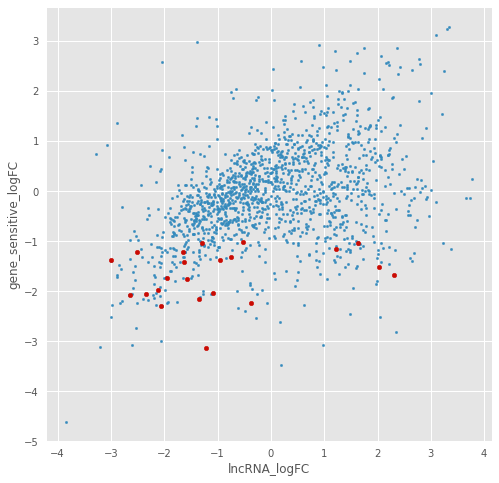

In [215]:
fig,ax=plt.subplots(figsize=(8,8))
corr_table.plot(kind='scatter',x='lncRNA_logFC',y='gene_sensitive_logFC', ax=ax, s=5)
select = select.split(', ')
corr_table[corr_table['gene_sensitive'].isin(select)].plot(
    kind='scatter',x='lncRNA_logFC',y='gene_sensitive_logFC',ax=ax,c='r')



In [216]:
corr_table[corr_table['gene_sensitive'].isin(select)]

,lncRNA,lncRNA_logFC,gene_sensitive,gene_sensitive_logFC
232,KS17gene_1251a,-1.943718,Tb927.6.4770,-1.727259
321,KS17gene_1750a,-1.080347,Tb927.8.2780,-2.038505
359,KS17gene_1955a,-1.284512,Tb927.8.6080,-1.040035
483,KS17gene_2688a,-0.363274,Tb927.10.2190,-2.229885
537,KS17gene_3105a,-3.007414,Tb927.10.11760,-1.379225
546,KS17gene_3167a,-0.513435,Tb927.10.14930,-1.014842
581,KS17gene_3427a,-2.344591,Tb927.11.2250,-2.054060
589,KS17gene_3460a,-1.633342,Tb927.11.3300,-1.414082
591,KS17gene_3477a,-2.108197,Tb927.11.3440,-1.980284
721,KS17gene_4280a,1.223698,Tb927.11.14100,-1.157413


In [142]:
selected = merge[ (merge['logFC']>0) &
              (merge['logCPM']>1) & 
              (merge['FDR']<0.01) ]['reg_type']
selected.value_counts()

none        568
increase     19
decrease     12
Name: reg_type, dtype: int64

In [143]:
merge['selected'] = [1 if n in selected.dropna().index.values else 0 for n in merge.index.values]
merge.index.name = 'gene_ks'

In [144]:
merge.reset_index()[['gene_ks',
                    'gene_sensitive',
                    'logFC','logCPM','LR',
                    'PValue','FDR','reg_type','desc','selected']].to_csv('Tables/Table_6.csv')

In [164]:
merge.head()

,Chro,Source,ttype,start,end,orient,gene_sensitive,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,reg_type,desc,selected
gene_ks,,,,,,,,,,,,,,,,,
KS17gene_30a,Tb927_01_v5.1,FGuegan,transcript,107289,107927,+,Tb927.1.270,1.240350,5.248472,383.374211,2.292719e-85,2.349711e-84,84.639649,83.628986,none,hypothetical protein,1
KS17gene_32a,Tb927_01_v5.1,FGuegan,transcript,118542,119207,+,Tb927.1.290,0.435877,4.660377,10.934628,9.438343e-04,1.273044e-03,3.025104,2.895157,none,leucine-rich repeat protein (LRRP) putative,1
KS17gene_34a,Tb927_01_v5.1,FGuegan,transcript,149570,151104,+,Tb927.1.400,3.344811,6.526367,1506.956076,0.000000e+00,0.000000e+00,inf,inf,none,hypothetical protein conserved,1
KS17gene_37a,Tb927_01_v5.1,FGuegan,transcript,187252,187918,+,Tb927.1.480,0.767233,5.384274,77.576377,1.276882e-18,2.991866e-18,17.893849,17.524058,none,leucine-rich repeat protein (LRRP) putative,1
KS17gene_46a,Tb927_01_v5.1,FGuegan,transcript,322959,323112,+,Tb927.1.1175,-0.410615,3.138953,10.532380,1.173011e-03,1.570776e-03,2.930698,2.803886,none,hypothetical protein,0


In [145]:
merge.loc['KS17gene_3137a']

Chro                                Tb927_10_v5.1
Source                                    FGuegan
ttype                                  transcript
start                                     2944385
end                                       2944781
orient                                          +
gene_sensitive                     Tb927.10.12080
logFC                                     2.23163
logCPM                                    3.07361
LR                                         369.14
PValue                                 2.8808e-82
FDR                                   2.75978e-81
log_PValue                                81.5405
log_FDR                                   80.5591
reg_type                                     none
desc              hypothetical protein  conserved
selected                                        1
Name: KS17gene_3137a, dtype: object

## CDS analysis

In [146]:
exp = '{life_stage}_{fraction}_{replica}'
list_df = [exp.format(
    life_stage=life_stage,
    fraction=fraction,
    replica=replica) 
 for life_stage in ['B','P']
 for fraction in ['tot','pol','sub']
 for replica in ['1','2','3']
            ]
list_df = [n+'/res3/'+n+'/counts_CDS.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in list_df[1:]:
    df = df.join(temp_df.iloc[:,-1])
df.head()


,Chr,Start,End,Strand,Length,/tmp/2109.1.all.q/B_tot_1/B_tot_1_sorted.bam,/tmp/2112.1.all.q/B_tot_2/B_tot_2_sorted.bam,/tmp/2115.1.all.q/B_tot_3/B_tot_3_sorted.bam,/tmp/2108.1.all.q/B_pol_1/B_pol_1_sorted.bam,/tmp/2111.1.all.q/B_pol_2/B_pol_2_sorted.bam,...,/tmp/2116.1.all.q/B_sub_3/B_sub_3_sorted.bam,/tmp/2118.1.all.q/P_tot_1/P_tot_1_sorted.bam,/tmp/2121.1.all.q/P_tot_2/P_tot_2_sorted.bam,/tmp/2124.1.all.q/P_tot_3/P_tot_3_sorted.bam,/tmp/2117.1.all.q/P_pol_1/P_pol_1_sorted.bam,/tmp/2120.1.all.q/P_pol_2/P_pol_2_sorted.bam,/tmp/2123.1.all.q/P_pol_3/P_pol_3_sorted.bam,/tmp/2119.1.all.q/P_sub_1/P_sub_1_sorted.bam,/tmp/2122.1.all.q/P_sub_2/P_sub_2_sorted.bam,/tmp/2125.1.all.q/P_sub_3/P_sub_3_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,1,1,0,0,0,...,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [147]:
data_col = df.columns[5:]
data_col

Index(['/tmp/2109.1.all.q/B_tot_1/B_tot_1_sorted.bam',
       '/tmp/2112.1.all.q/B_tot_2/B_tot_2_sorted.bam',
       '/tmp/2115.1.all.q/B_tot_3/B_tot_3_sorted.bam',
       '/tmp/2108.1.all.q/B_pol_1/B_pol_1_sorted.bam',
       '/tmp/2111.1.all.q/B_pol_2/B_pol_2_sorted.bam',
       '/tmp/2114.1.all.q/B_pol_3/B_pol_3_sorted.bam',
       '/tmp/2110.1.all.q/B_sub_1/B_sub_1_sorted.bam',
       '/tmp/2113.1.all.q/B_sub_2/B_sub_2_sorted.bam',
       '/tmp/2116.1.all.q/B_sub_3/B_sub_3_sorted.bam',
       '/tmp/2118.1.all.q/P_tot_1/P_tot_1_sorted.bam',
       '/tmp/2121.1.all.q/P_tot_2/P_tot_2_sorted.bam',
       '/tmp/2124.1.all.q/P_tot_3/P_tot_3_sorted.bam',
       '/tmp/2117.1.all.q/P_pol_1/P_pol_1_sorted.bam',
       '/tmp/2120.1.all.q/P_pol_2/P_pol_2_sorted.bam',
       '/tmp/2123.1.all.q/P_pol_3/P_pol_3_sorted.bam',
       '/tmp/2119.1.all.q/P_sub_1/P_sub_1_sorted.bam',
       '/tmp/2122.1.all.q/P_sub_2/P_sub_2_sorted.bam',
       '/tmp/2125.1.all.q/P_sub_3/P_sub_3_sorted.bam'],
      dty

In [148]:
print(df.shape)
#indata = df[df['sumValues']>200][data_col]
indata = df[data_col]
indata.columns = [n.split('/')[3] for  n in indata.columns]


indata.head()
print(indata.shape)
indata.reset_index(inplace=True)
indata.head()

(19303, 23)
(19303, 18)


,Geneid,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
0,Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
1,Tb10.v4.0074,0,0,1,1,0,0,2,2,1,0,0,0,0,0,0,0,0,0
2,Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [149]:
#indata.Geneid.value_counts()

In [150]:
#indata = indata.groupby('Geneid').sum().reset_index()
#indata = indata.drop_duplicates('Geneid')
#indata.set_index('Geneid',inplace=True)
#print(indata.shape)
#indata.head()

In [151]:
%%R -i indata
rownames(indata) <- indata$Geneid
indata <- subset(indata, select = -c(Geneid))
library("limma") 
library("edgeR")

In [152]:
%%R
group <- factor(c(
    'Btot','Btot','Btot',
    'Bpol','Bpol','Bpol',
    'Bsub','Bsub','Bsub',
    'Ptot','Ptot','Ptot',
    'Ppol','Ppol','Ppol',
    'Psub','Psub','Psub'))
y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]
y <- calcNormFactors(y)
design <- model.matrix(~group)
y <- estimateDisp(y,design)
cpm_df <- cpm(y)
genes = row.names(y)
head(genes)

[1] "Tb927.8.230" "Tb927.8.480" "Tb927.8.490" "Tb927.8.500" "Tb927.8.510"
[6] "Tb927.8.520"


In [153]:
%R -o cpm_df,genes
indata.set_index('Geneid',inplace=True)
out_df = pd.DataFrame(cpm_df,index=genes,columns=indata.columns)

out_df.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.230,0.100202,0.000000,0.113762,0.079234,0.154251,0.220445,0.378188,0.557813,0.763507,0.030236,0.000000,0.000000,0.000000,0.000000,0.046563,0.000000,0.000000,0.000000
Tb927.8.480,6.513106,13.279372,11.793277,4.357891,8.715196,4.666089,3.183079,5.875629,2.654096,1.269924,0.803436,0.762241,0.548230,0.490621,0.558754,4.609848,3.141163,3.482258
Tb927.8.490,3.573858,4.497852,5.877678,3.010906,3.817718,3.821050,7.626783,10.040632,13.452266,2.267721,1.740777,2.197048,2.028451,1.694873,2.281580,3.733596,3.763469,5.610305
Tb927.8.500,0.868414,1.642073,1.858105,0.554641,0.732693,0.587854,7.500720,10.338132,13.161406,0.876852,0.602577,0.538053,0.274115,0.178408,0.186251,2.133483,2.667025,3.578988
Tb927.8.510,1.269221,1.570678,1.440979,0.396172,1.002633,0.734817,2.773376,4.016253,7.562355,2.358430,1.941636,2.197048,1.425398,1.427262,1.909077,4.076477,4.030171,7.061246


In [154]:
pcf_ribo = pd.read_csv('InData/PolisomeLiterature/PCF.csv',index_col=[0])
pcf_ribo.columns = ['PCF_'+n for n in pcf_ribo.columns]
bsf_ribo = pd.read_csv('InData/PolisomeLiterature/BSF.csv',index_col=[0])
bsf_ribo.columns = ['BSF_'+n for n in bsf_ribo.columns]
ribo = pcf_ribo.join(bsf_ribo,how='outer')
ribo = ribo.reset_index()
ribo=ribo.replace('#DIV/0!',np.nan)
ribo_lookup = pd.read_csv('InData/PolisomeLiterature/GeneByLocusTag_Summary.txt',sep='\t')
ribo_lookup.head()
ribo_df = ribo_lookup.merge(ribo,left_on='Input ID',right_on='2013Latest_numbers',how='outer')
#hl_df.head()
ribo_df.set_index('Gene ID',inplace=True)
ribo_df.head()

,Genomic Location (Gene),Product Description,Gene Type,Input ID,Unnamed: 5,2013Latest_numbers,PCF_Annotation,PCF_Class,PCF_Orthologue count,PCF_ORF length,...,BSF_BS RNAs/cell pA+ fragments,BSF_Log 2 BS RNAs/cell pA+ fragments,BSF_RPM Ribosome profiling,BSF_RPM Ribsome profiling x orthogue count,BSF_Ribosomes/cell/gene,BSF_Ribosomes/mRNA,BSF_Ribosomes/kb BS,BSF_Fraction in polysomes,BSF_mRNA abundance BS/PC (Silicotryp),"BSF_ribosomes/kb, BS/PC"
Gene ID,,,,,,,,,,,,,,,,,,,,,
Tb927.1.1000,"Tb927_01_v5.1:289,877..291,155(+)",developmentally regulated phosphoprotein,protein coding,Tb927.1.1000,NaN,Tb927.1.1000,developmentally regulated phosphoprotein (dr6),Mito.pathway,1.0,1263.0,...,2.05,1.04,29.16,29.16,2.56,1.85,1.46,0.615,0.89,0.408
Tb927.1.1010,"Tb927_01_v5.1:291,565..293,744(+)","E3 ubiquitin-protein ligase KCMF1, putative",protein coding,Tb927.1.1010,NaN,Tb927.1.1010,"hypothetical protein, conserved",ZUnknown,1.0,2160.0,...,3.10,1.63,72.05,72.05,6.32,6.12,2.83,0.703,1.52,1.429
Tb927.1.1020,"Tb927_01_v5.1:294,104..296,172(+)",leucine-rich repeat-containing protein,protein coding,Tb927.1.1020,NaN,Tb927.1.1020,"hypothetical protein, conserved",ZUnknown,1.0,1281.0,...,2.29,1.20,62.21,62.21,5.46,3.77,2.94,0.724,1.72,2.297
Tb927.1.1030,"Tb927_01_v5.1:296,918..298,629(+)",Nucleolar protein 49,protein coding,Tb927.1.1030,NaN,Tb927.1.1030,leucine-rich repeat protein (LRRP),LRRP,1.0,1374.0,...,2.94,1.55,39.31,39.31,3.45,1.37,1.00,0.596,1.27,0.806
Tb927.1.1050,"Tb927_01_v5.1:298,769..303,453(+)",Metallo-dependent phosphatase-like domain-cont...,protein coding,Tb927.1.1050,NaN,Tb927.1.1050,"hypothetical protein, conserved",ZUnknown,1.0,3357.0,...,3.09,1.63,102.38,102.38,8.98,4.94,1.47,0.755,2.60,0.317


## Fig 5
Antwi, et al., 2016

without trimming the x-axes of BSF sample

https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-016-2624-3/figures/6

In [155]:
test = pd.concat([ribo_df['BSF_Fraction in polysomes'].astype(float),
                 ribo_df['PCF_Fraction in polysomes'].astype(float),
                 np.log10(ribo_df['BSF_Ribosomes/kb BS'].astype(float)),
                 np.log10(ribo_df['PCF_Ribosomes/kb'].astype(float))],axis=1)
test=test.replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()

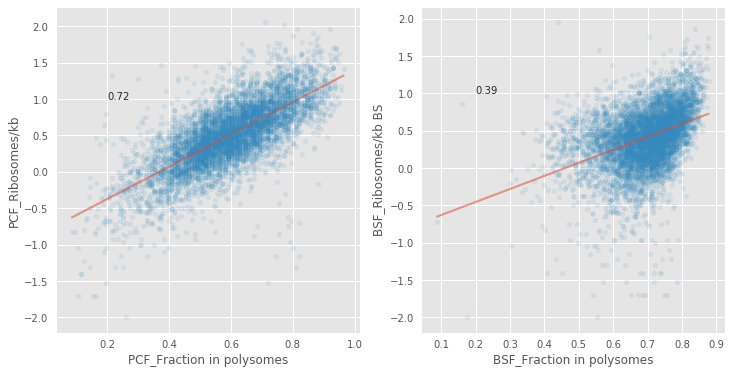

In [156]:
import scipy as sp
def plot_line(x,y,ax):
    linreg = sp.stats.linregress(x, y)
    ax.plot(x, linreg.slope*x + linreg.intercept,alpha=0.5)
    ax.text(0.2, 1, round(linreg.rvalue,2))

fig,axes=plt.subplots(figsize=(12,6),ncols=2)
ax=axes[1]
x='BSF_Fraction in polysomes'
y='BSF_Ribosomes/kb BS'
test.plot(x=x,
          y=y,kind='scatter',ax=ax,
         alpha=0.1)
plot_line(test[x],test[y],ax)
ax=axes[0]
x='PCF_Fraction in polysomes'
y='PCF_Ribosomes/kb'
test.plot(x='PCF_Fraction in polysomes',
          y='PCF_Ribosomes/kb',kind='scatter',ax=ax,
         alpha=0.1)
plot_line(test[x],test[y],ax)

In [157]:
TDdf2 = pd.concat([
        #Traslation Competent BSF
        ((out_df['B_pol_1']*0.7) / ((out_df['B_pol_1']*0.7) + (out_df['B_sub_1']*0.3))),
        ((out_df['B_pol_2']*0.7) / ((out_df['B_pol_2']*0.7) + (out_df['B_sub_2']*0.3))),
        ((out_df['B_pol_3']*0.7) / ((out_df['B_pol_3']*0.7) + (out_df['B_sub_3']*0.3))),
        #Traslation Competent PCF
        ((out_df['P_pol_1']*0.7) / ((out_df['P_pol_1']*0.7) + (out_df['P_sub_1']*0.3))),
        ((out_df['P_pol_2']*0.7) / ((out_df['P_pol_2']*0.7) + (out_df['P_sub_2']*0.3))),
        ((out_df['P_pol_3']*0.7) / ((out_df['P_pol_3']*0.7) + (out_df['P_sub_3']*0.3)))],
        #BSF vs PCF
         axis=1)


TDdf2.columns = ['B1','B2','B3','P1','P2','P3']
TDdf2['median_b']=TDdf2[['B1','B2','B3']].median(axis=1)
TDdf2['median_p']=TDdf2[['P1','P2','P3']].median(axis=1)
TDdf2.head()

,B1,B2,B3,P1,P2,P3,median_b,median_p
Tb927.8.230,0.328345,0.392184,0.402520,NaN,NaN,1.000000,0.392184,1.000000
Tb927.8.480,0.761594,0.775834,0.804005,0.217217,0.267102,0.272410,0.775834,0.267102
Tb927.8.490,0.479480,0.470113,0.398595,0.559023,0.512389,0.486893,0.470113,0.512389
Tb927.8.500,0.147149,0.141904,0.094382,0.230646,0.135012,0.108279,0.141904,0.135012
Tb927.8.510,0.249988,0.368089,0.184821,0.449304,0.452456,0.386819,0.249988,0.449304


In [158]:
test=test.join(TDdf2[['median_b','median_p']]).replace(-np.inf,np.nan).replace(np.inf,np.nan).dropna()
test.head()

,BSF_Fraction in polysomes,PCF_Fraction in polysomes,BSF_Ribosomes/kb BS,PCF_Ribosomes/kb,median_b,median_p
Tb927.1.1000,0.615,0.585,0.164353,0.553883,0.749996,0.739500
Tb927.1.1010,0.703,0.475,0.451786,0.296665,0.698373,0.624344
Tb927.1.1020,0.724,0.450,0.468347,0.107210,0.771219,0.687187
Tb927.1.1030,0.596,0.445,0.000000,0.093422,0.516573,0.608642
Tb927.1.1050,0.755,0.665,0.167317,0.666518,0.865666,0.731815


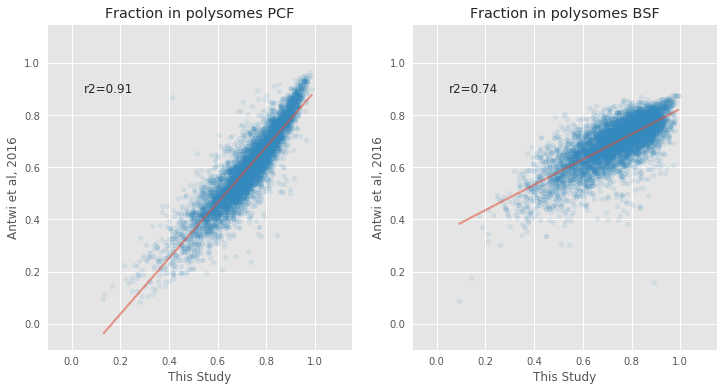

In [163]:
test=test.dropna()

fig,axes=plt.subplots(figsize=(12,6), ncols=2)

x='median_b'
y='BSF_Fraction in polysomes'
test.plot(x=x,
          y=y,kind='scatter',ax=axes[1],
          alpha=0.1)
UT.plot_line(test[x],test[y],axes[1])


axes[1].set_title('Fraction in polysomes BSF')
axes[1].set_xlim(-0.1,1.15)
axes[1].set_ylim(-0.1,1.15)
axes[1].set_ylabel('Antwi et al, 2016')
axes[1].set_xlabel('This Study')


x='median_p'
y='PCF_Fraction in polysomes'
test.plot(x=x,
          y=y,kind='scatter',ax=axes[0],
         alpha=0.1)
UT.plot_line(test[x],test[y],axes[0])


axes[0].set_title('Fraction in polysomes PCF')
axes[0].set_xlim(-0.1,1.15)
axes[0].set_ylim(-0.1,1.15)
axes[0].set_ylabel('Antwi et al, 2016')
axes[0].set_xlabel('This Study')

plt.savefig('Figures/Figure_5.png')
plt.show()